# Gold Price Prediction - Comprehensive Modeling Analysis

**Objective:** Build and compare statistical, machine learning, and deep learning models for gold price prediction using proper time-series validation.

**Key Principles:**
- ✅ Time-based train-test split (NO shuffle) across ALL models
- ✅ Consistent evaluation metrics (R², Adj-R², MSE, RMSE, MAE)
- ✅ Reproducible results (SEED=42)
- ✅ Proper scaling for numerical stability

## 1. Setup and Configuration

In [40]:
# ============================================================
# 1.1. Import Libraries
# ============================================================

# Data manipulation
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Statistical modeling
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

# Machine Learning
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tqdm.keras import TqdmCallback

# Utilities
import ace_tools_open as tools
import random
import os
from time import time

In [41]:
# ============================================================
# 1.2. Configuration and Reproducibility
# ============================================================

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Global constants
TRAIN_RATIO = 0.8
WINDOW_SIZE = 12  # For time-series sequences (1 year of monthly data)
TEST_SIZE = 1 - TRAIN_RATIO

# Plotting configuration
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print(f"Configuration:")
print(f"  SEED: {SEED}")
print(f"  TRAIN_RATIO: {TRAIN_RATIO}")
print(f"  WINDOW_SIZE: {WINDOW_SIZE}")
print(f"  TensorFlow version: {tf.__version__}")

Configuration:
  SEED: 42
  TRAIN_RATIO: 0.8
  WINDOW_SIZE: 12
  TensorFlow version: 2.20.0


## 2. Data Loading and Preprocessing

In [42]:
# ============================================================
# 2.1. Load Dataset
# ============================================================

df = pd.read_csv("../data/filtered_data.csv", index_col="Date", parse_dates=True)

# Handle missing values
df = df.ffill()

# Rename columns for consistency
df.rename(columns={"^VIX": "VIX", "Silver_Fututes": "Silver_Futures"}, inplace=True)

print(f"Shape: {df.shape}")

tools.display_dataframe_to_user(name="Filtered Gold Price Dataset", dataframe=df)

Shape: (233, 13)
Filtered Gold Price Dataset


Loading ITables v2.4.3 from the internet... (need help?)


In [43]:
# ============================================================
# 2.2. Unified Time-Based Split Function
# ============================================================

def time_based_split(X, y, train_ratio=TRAIN_RATIO):
    """
    Split time-series data using time-based indexing (NO SHUFFLE).
    
    Parameters:
        X: Features (DataFrame or ndarray)
        y: Target (Series or ndarray)
        train_ratio: Proportion of data for training
    
    Returns:
        X_train, X_test, y_train, y_test
    """
    split_idx = int(len(X) * train_ratio)
    
    if isinstance(X, pd.DataFrame):
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    else:
        X_train, X_test = X[:split_idx], X[split_idx:]
    
    if isinstance(y, pd.Series):
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    else:
        y_train, y_test = y[:split_idx], y[split_idx:]
    
    return X_train, X_test, y_train, y_test

In [44]:
# ============================================================
# 2.3. Prepare Features and Target
# ============================================================

# Separate features and target
X = df.drop(columns=["Gold_Spot"])
y = df["Gold_Spot"]

# Time-based split
X_train, X_test, y_train, y_test = time_based_split(X, y)

# Initialize scalers
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit scalers on training data only
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

print("\n" + "="*60)
print("DATA SPLIT SUMMARY (Time-Based, No Shuffle)")
print("="*60)
print(f"Train period: {df.index[0]} to {df.index[len(X_train)-1]}")
print(f"Test period:  {df.index[len(X_train)]} to {df.index[-1]}")
print(f"\nTrain size: {len(X_train)} samples ({TRAIN_RATIO*100:.0f}%)")
print(f"Test size:  {len(X_test)} samples ({TEST_SIZE*100:.0f}%)")
print(f"Features:   {X.shape[1]}")
print("="*60)


DATA SPLIT SUMMARY (Time-Based, No Shuffle)
Train period: 2006-01-31 00:00:00 to 2021-06-30 00:00:00
Test period:  2021-07-30 00:00:00 to 2025-05-30 00:00:00

Train size: 186 samples (80%)
Test size:  47 samples (20%)
Features:   12


## 3. Exploratory Data Analysis

In [45]:
# ============================================================
# 3.1. Dataset Statistics
# ============================================================

print("Descriptive Statistics:")
display(df.describe())

print("\nMissing Values:")
display(df.isnull().sum())

Descriptive Statistics:


,Gold_Spot,Silver_Futures,SP_500,VIX,USD_Index,CPI,Unemployment,Treasury_Yield_10Y,Real_Interest_Rate,Fed_Funds_Rate,Crude_Oil,GPR,GPRA
count,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000
mean,1419.796395,20.546086,2494.471197,19.649571,105.682119,246.385554,5.820172,2.868283,0.782532,1.664249,72.772747,99.911064,92.895815
std,500.697016,6.925697,1367.810799,8.247290,12.362439,32.773538,2.178752,1.112929,1.006765,1.976267,21.224799,29.647565,34.925171
min,549.860000,9.720000,735.090027,9.510000,85.599900,199.300000,3.400000,0.620000,-1.160000,0.050000,18.840000,58.420769,28.454628
25%,1151.400000,15.551000,1377.939941,13.750000,93.629100,219.590000,4.100000,1.980000,0.150000,0.120000,55.169998,81.499825,70.097443
50%,1316.180000,18.440001,2067.560059,17.350000,108.390100,237.657000,4.900000,2.720000,0.650000,0.390000,71.720001,92.016479,86.384369
75%,1742.620000,24.472000,3269.959961,23.379999,115.771700,259.250000,7.500000,3.730000,1.630000,2.610000,88.910004,110.528946,106.979088
max,3277.990000,48.584000,6040.529785,59.889999,129.488000,320.580000,14.800000,5.110000,3.140000,5.330000,140.000000,318.954926,250.955856



Missing Values:


Gold_Spot             0
Silver_Futures        0
SP_500                0
VIX                   0
USD_Index             0
CPI                   0
Unemployment          0
Treasury_Yield_10Y    0
Real_Interest_Rate    0
Fed_Funds_Rate        0
Crude_Oil             0
GPR                   0
GPRA                  0
dtype: int64

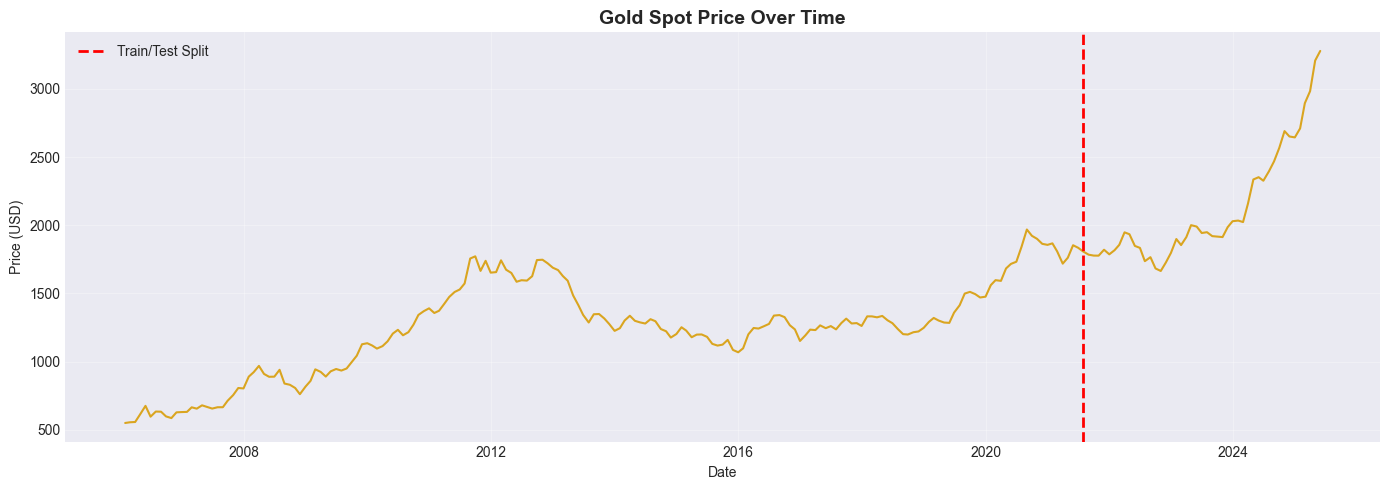

In [46]:
# ============================================================
# 3.2. Gold Price Time Series
# ============================================================

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df.index, df["Gold_Spot"], linewidth=1.5, color='goldenrod')
ax.axvline(df.index[len(X_train)], color='red', linestyle='--', linewidth=2, label='Train/Test Split')
ax.set_title("Gold Spot Price Over Time", fontsize=14, fontweight='bold')
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

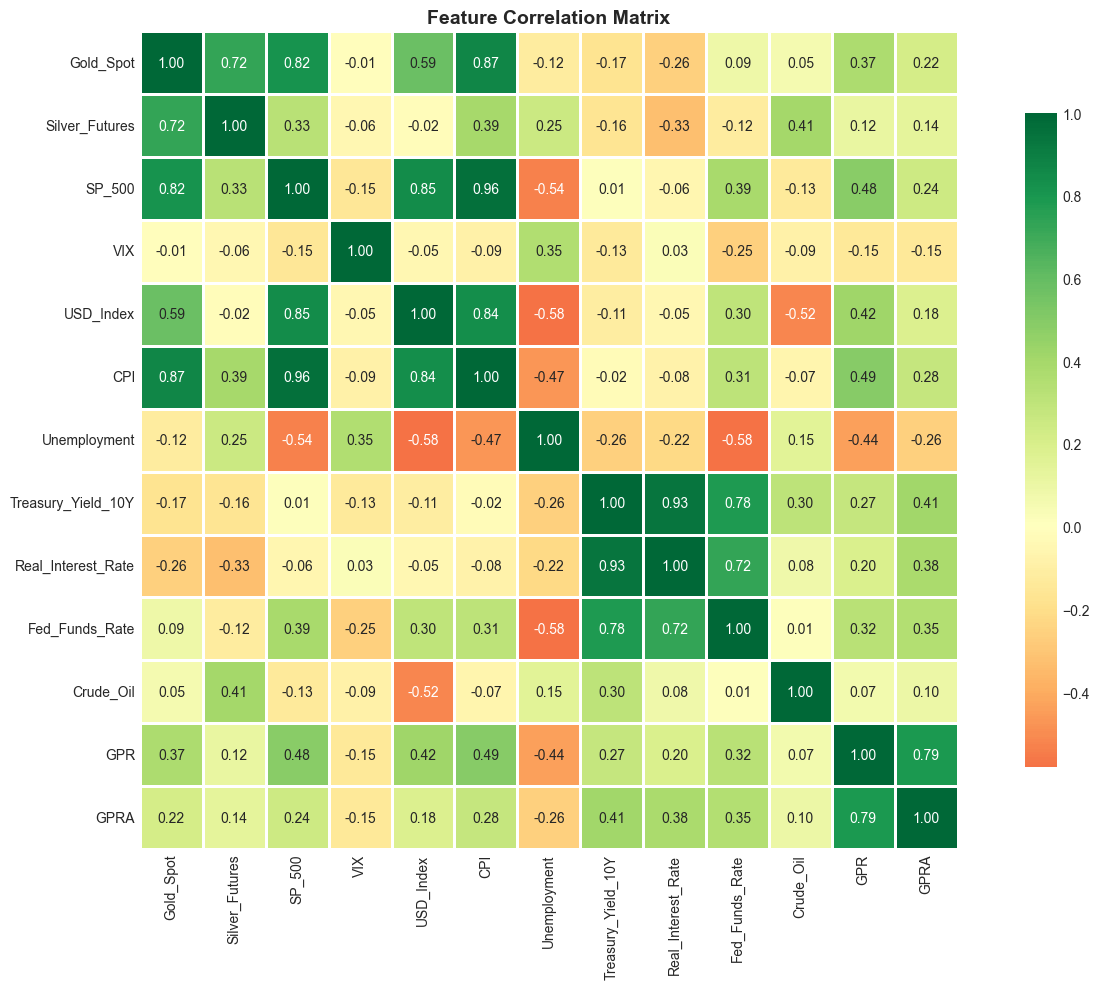


High Correlations with Gold_Spot (|corr| > 0.5):


CPI               0.867822
SP_500            0.816790
Silver_Futures    0.723550
USD_Index         0.585260
Name: Gold_Spot, dtype: float64

In [47]:
# ============================================================
# 3.3. Correlation Heatmap
# ============================================================

plt.figure(figsize=(14, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title("Feature Correlation Matrix", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Identify high correlations
print("\nHigh Correlations with Gold_Spot (|corr| > 0.5):")
gold_corr = corr_matrix["Gold_Spot"].drop("Gold_Spot").sort_values(ascending=False)
display(gold_corr[abs(gold_corr) > 0.5])

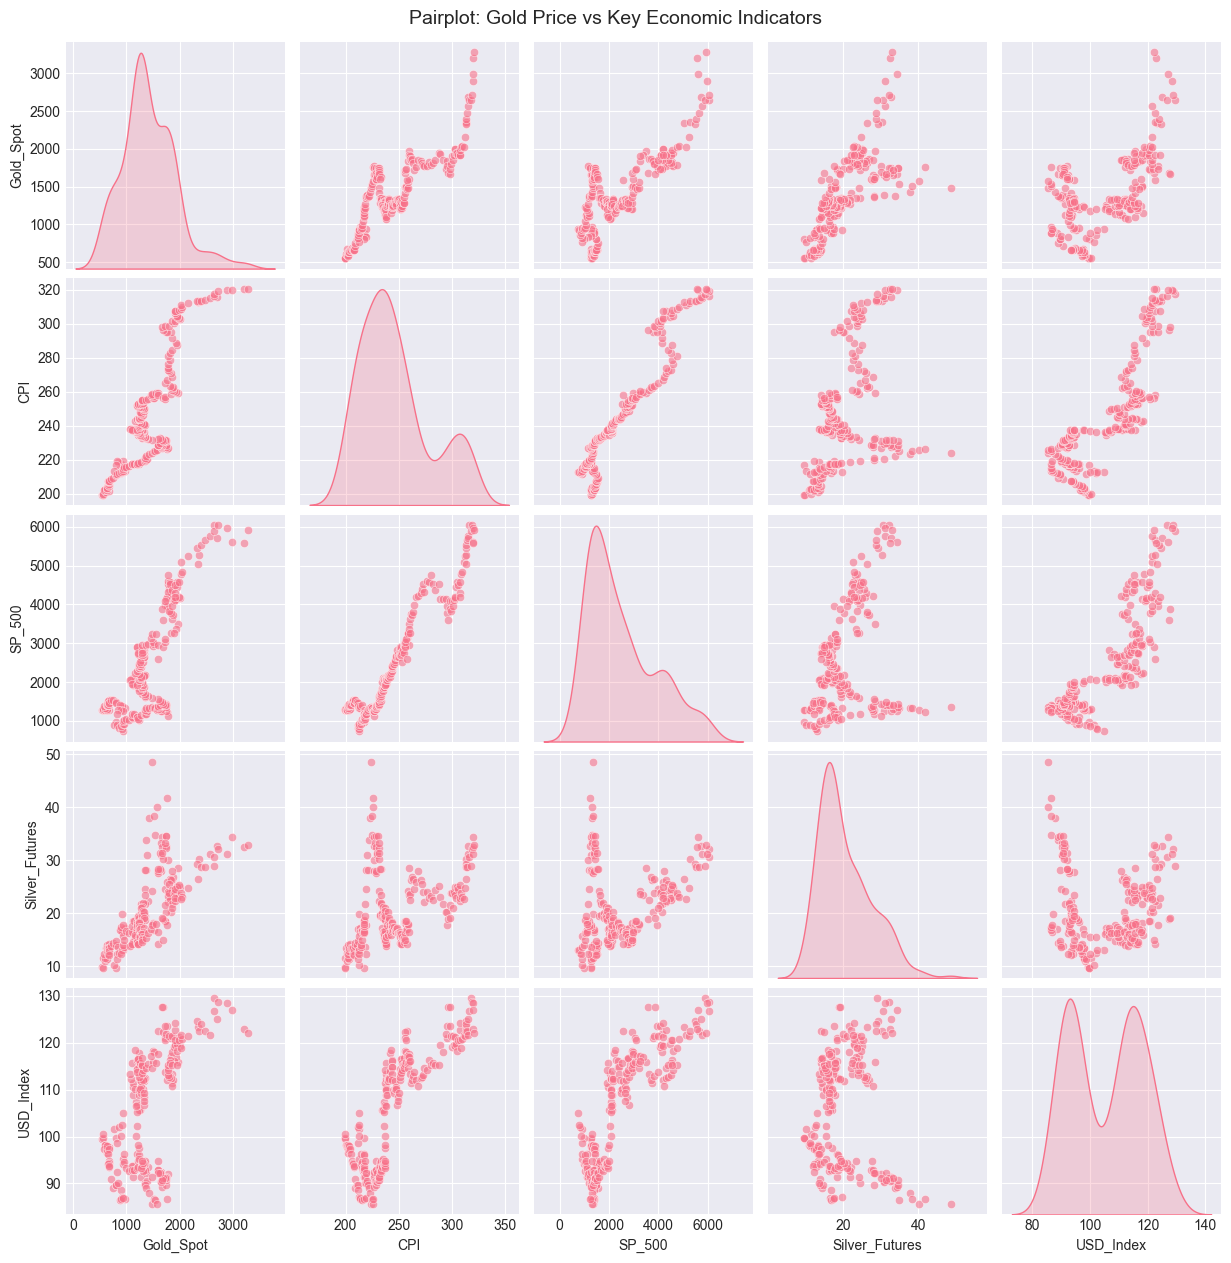

In [48]:
# ============================================================
# 3.4. Pairplot: Gold_Spot vs Key Features
# ============================================================

key_features = ["Gold_Spot", "CPI", "SP_500", "Silver_Futures", "USD_Index"]
sns.pairplot(df[key_features], diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle("Pairplot: Gold Price vs Key Economic Indicators", y=1.01, fontsize=14)
plt.show()


Variance Inflation Factor (VIF) - Multicollinearity Check:
(VIF > 10 indicates high multicollinearity)


,Feature,VIF
4,CPI,1860.695818
3,USD_Index,1049.206577
6,Treasury_Yield_10Y,193.163665
9,Crude_Oil,77.157605
10,GPR,52.838751
1,SP_500,47.444070
0,Silver_Futures,36.164571
7,Real_Interest_Rate,31.933887
11,GPRA,31.654986
5,Unemployment,24.289562


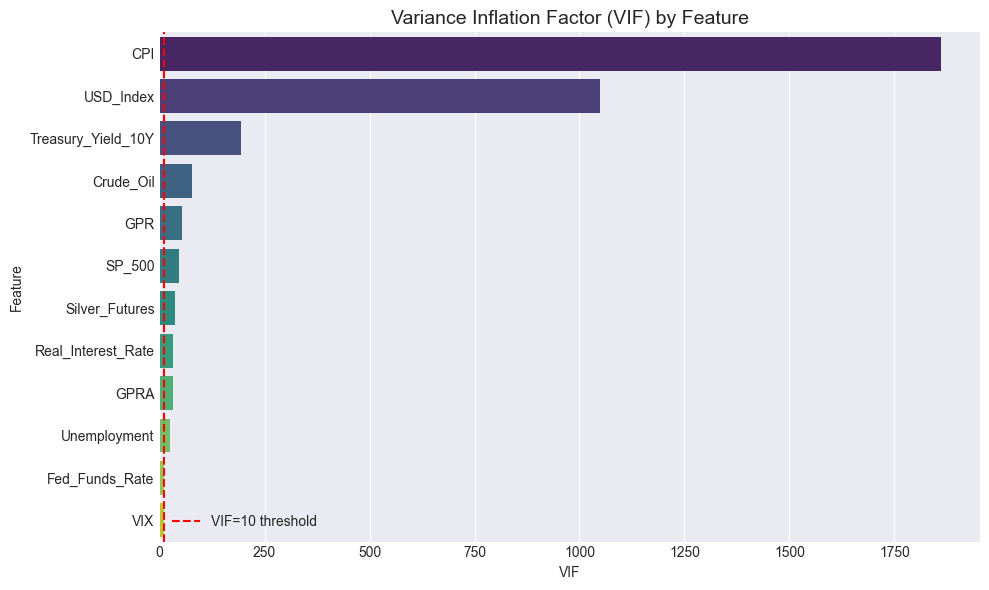

In [49]:
# ============================================================
# 3.5. Variance Inflation Factor (VIF)
# ============================================================

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data.sort_values(by="VIF", ascending=False)

print("\nVariance Inflation Factor (VIF) - Multicollinearity Check:")
print("(VIF > 10 indicates high multicollinearity)")
display(vif_data)

# Visualize VIF
plt.figure(figsize=(10, 6))
sns.barplot(data=vif_data, x="VIF", y="Feature", palette="viridis")
plt.axvline(10, color='red', linestyle='--', label='VIF=10 threshold')
plt.title("Variance Inflation Factor (VIF) by Feature", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

## 4. Baseline Models: Statistical Approaches

In [50]:
# ============================================================
# 4.1. Evaluation Function
# ============================================================

def evaluate_model(y_true, y_pred, n_features=1, model_name="Model"):
    """
    Calculate regression metrics with proper adjusted R².
    
    Parameters:
        y_true: Actual values
        y_pred: Predicted values
        n_features: Number of features used
        model_name: Name for display
    
    Returns:
        Dictionary of metrics
    """
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    
    # Adjusted R² formula
    if n > n_features + 1:
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    else:
        adj_r2 = r2
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    return {
        "Model": model_name,
        "R²": round(r2, 4),
        "Adj_R²": round(adj_r2, 4),
        "MSE": round(mse, 2),
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2)
    }

### Simple Linear Regression (Univariate)

SIMPLE LINEAR REGRESSION (Each Feature vs Gold_Spot)


,Model,R²,Adj_R²,MSE,RMSE,MAE,Coefficient,F-value,p-value
4,CPI,0.4162,0.4032,99596.31,315.59,262.87,14.0991,216.80,0.0000
1,SP_500,0.2064,0.1888,135391.37,367.96,247.00,0.2266,68.95,0.0000
0,Silver_Futures,-2.0793,-2.1477,525334.92,724.80,665.79,35.1757,196.77,0.0000
3,USD_Index,-2.9177,-3.0048,668378.96,817.54,715.05,8.0293,11.97,0.0007
9,Crude_Oil,-4.4546,-4.5759,930578.49,964.66,872.41,-0.2224,0.04,0.8415
2,VIX,-4.4605,-4.5818,931577.14,965.18,871.26,1.9031,0.44,0.5065
5,Unemployment,-5.7379,-5.8877,1149512.42,1072.15,991.44,50.7727,21.49,0.0000
10,GPR,-6.9417,-7.1181,1354872.98,1163.99,1055.41,-4.5078,10.51,0.0014
11,GPRA,-7.1058,-7.2859,1382878.64,1175.96,1045.56,-4.8247,30.29,0.0000
7,Real_Interest_Rate,-7.8333,-8.0296,1506984.24,1227.59,1024.35,-333.6367,1167.30,0.0000


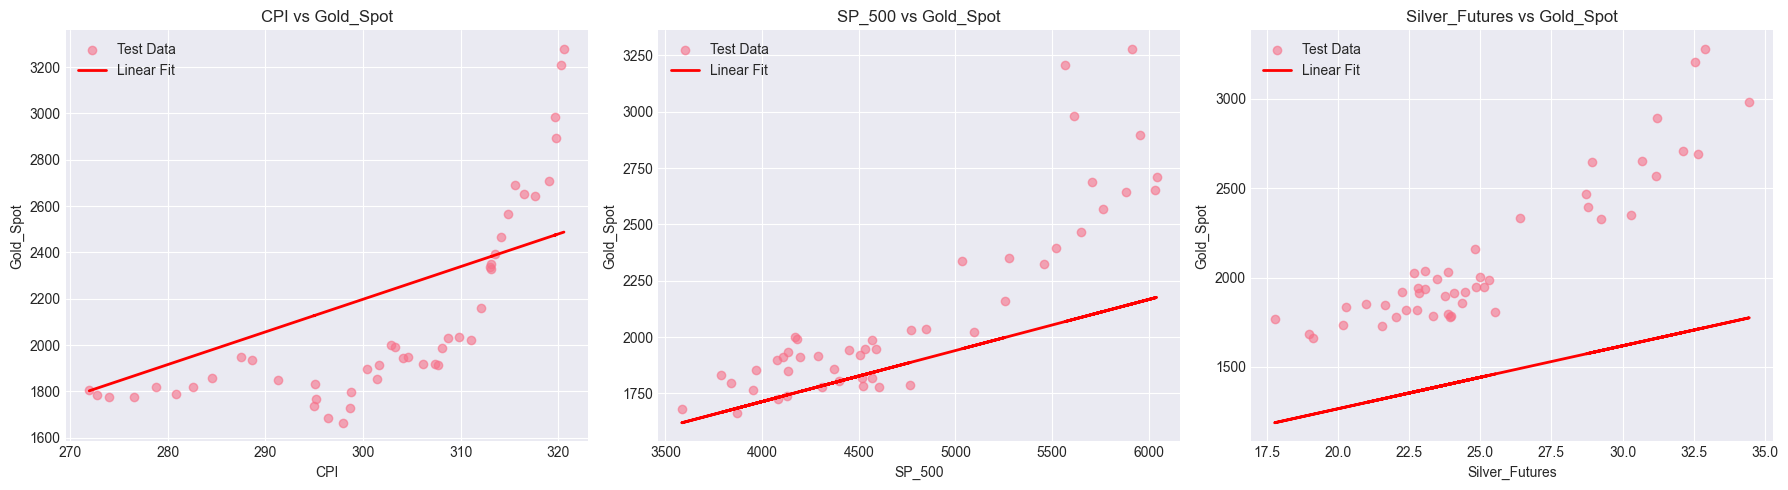

In [51]:
# ============================================================
# 4.2. Simple Linear Regression (Univariate)
# ============================================================

print("="*60)
print("SIMPLE LINEAR REGRESSION (Each Feature vs Gold_Spot)")
print("="*60)

results_univariate = []

for feature in X.columns:
    # Prepare data
    X_single = X[[feature]]
    X_tr, X_te, y_tr, y_te = time_based_split(X_single, y)
    
    # Fit model
    model = LinearRegression()
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    
    # ANOVA test using statsmodels
    train_df = X_tr.copy()
    train_df["Gold_Spot"] = y_tr
    formula = f"Gold_Spot ~ {feature}"
    ols_model = smf.ols(formula, data=train_df).fit()
    anova_table = anova_lm(ols_model, typ=2)
    
    # Store results
    metrics = evaluate_model(y_te, y_pred, n_features=1, model_name=feature)
    metrics["Coefficient"] = round(model.coef_[0], 4)
    metrics["F-value"] = round(anova_table["F"].iloc[0], 2)
    metrics["p-value"] = round(anova_table["PR(>F)"].iloc[0], 4)
    
    results_univariate.append(metrics)

# Display results
df_univariate = pd.DataFrame(results_univariate).sort_values(by="R²", ascending=False)
display(df_univariate)

# Visualize top 3 features
top_features = df_univariate.head(3)["Model"].values

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, feature in enumerate(top_features):
    X_single = X[[feature]]
    X_tr, X_te, y_tr, y_te = time_based_split(X_single, y)
    
    model = LinearRegression()
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    
    axes[idx].scatter(X_te, y_te, alpha=0.6, label="Test Data")
    axes[idx].plot(X_te, y_pred, color='red', linewidth=2, label="Linear Fit")
    axes[idx].set_title(f"{feature} vs Gold_Spot")
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel("Gold_Spot")
    axes[idx].legend()

plt.tight_layout()
plt.show()

### Multiple Linear Regression

In [52]:
# ============================================================
# 4.3. Multiple Linear Regression
# ============================================================

print("\n" + "="*60)
print("MULTIPLE LINEAR REGRESSION (All Features)")
print("="*60)

# Fit model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)

# Evaluate
metrics_lr = evaluate_model(y_test, y_pred_lr, n_features=X.shape[1], model_name="Linear Regression")

print(f"\nR²: {metrics_lr['R²']} | Adj R²: {metrics_lr['Adj_R²']}")
print(f"MSE: {metrics_lr['MSE']} | RMSE: {metrics_lr['RMSE']} | MAE: {metrics_lr['MAE']}")

# Coefficients
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lin_reg.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

print("\nFeature Coefficients:")
display(coef_df)

# OLS Summary
train_df_full = X_train.copy()
train_df_full["Gold_Spot"] = y_train
formula_full = "Gold_Spot ~ " + " + ".join(X.columns)
ols_full = smf.ols(formula_full, data=train_df_full).fit()

print("\n" + "="*60)
print("OLS REGRESSION SUMMARY")
print("="*60)
display(ols_full.summary())


MULTIPLE LINEAR REGRESSION (All Features)

R²: -0.1277 | Adj R²: -0.5257
MSE: 192390.76 | RMSE: 438.62 | MAE: 290.43

Feature Coefficients:


,Feature,Coefficient
7,Real_Interest_Rate,-113.342736
6,Treasury_Yield_10Y,-36.612322
8,Fed_Funds_Rate,27.865266
5,Unemployment,26.788135
0,Silver_Futures,17.285080
4,CPI,11.650825
3,USD_Index,-3.946389
2,VIX,2.774798
11,GPRA,-0.813344
9,Crude_Oil,-0.712257



OLS REGRESSION SUMMARY


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gold_Spot   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     722.0
Date:                Tue, 28 Oct 2025   Prob (F-statistic):          7.47e-141
Time:                        22:44:21   Log-Likelihood:                -983.20
No. Observations:                 186   AIC:                             1992.
Df Residuals:                     173   BIC:                             2034.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1308.3242    239.323     -5.467      0.000   -1780.693    -835.955
Silver_Futures        17.2851      1.023     16.894      0.000      15.266      19.304
SP_500                -0.0545      0.019     -2.904      0.004      -0.092      -0.017
VIX                    2.7748      0.606      4.581      0.000       1.579       3.970
USD_Index             -3.9464      1.585     -2.489      0.014      -7.075      -0.817
CPI                   11.6508      1.273      9.152      0.000       9.138      14.164
Unemployment          26.7881      3.172      8.445      0.000      20.527      33.049
Treasury_Yield_10Y   -36.6123     18.770     -1.951      0.053     -73.661       0.436
Real_Interest_Rate  -113.3427     19.526     -5.805      0.000    -151.883     -74.802
Fed_Funds_Rate        27.8653      5.874      4.744      0.000      16.272      39.458
Crude_Oil             -0.7123      0.484     -1.472      0.143      -1.667       0.243
GPR                    0.6350      0.353      1.799      0.074      -0.062       1.332
GPRA                  -0.8133      0.258     -3.149      0.002      -1.323      -0.304
==============================================================================
Omnibus:                       13.302   Durbin-Watson:                   1.087
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               34.942
Skew:                          -0.126   Prob(JB):                     2.58e-08
Kurtosis:                       5.108   Cond. No.                     1.38e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Ridge Regression with GridSearchCV

In [53]:
# ============================================================
# 4.4. Ridge Regression with GridSearchCV
# ============================================================

print("\n" + "="*60)
print("RIDGE REGRESSION (L2 Regularization)")
print("="*60)

ridge = Ridge()
param_grid_ridge = {"alpha": [0.01, 0.1, 1, 10, 100, 1000]}

grid_ridge = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring="r2", n_jobs=-1)
grid_ridge.fit(X_train, y_train)

best_ridge = grid_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)

metrics_ridge = evaluate_model(y_test, y_pred_ridge, n_features=X.shape[1], model_name="Ridge Regression")

print(f"Best alpha: {grid_ridge.best_params_['alpha']}")
print(f"Best CV R²: {grid_ridge.best_score_:.4f}")
print(f"\nTest Metrics:")
print(f"R²: {metrics_ridge['R²']} | Adj R²: {metrics_ridge['Adj_R²']}")
print(f"RMSE: {metrics_ridge['RMSE']} | MAE: {metrics_ridge['MAE']}")

# Compare coefficients: Linear vs Ridge
coef_compare = pd.DataFrame({
    "Feature": X.columns,
    "Linear_Coef": lin_reg.coef_,
    "Ridge_Coef": best_ridge.coef_
})
coef_compare["Difference"] = coef_compare["Linear_Coef"] - coef_compare["Ridge_Coef"]
display(coef_compare.sort_values(by="Difference", key=abs, ascending=False))


RIDGE REGRESSION (L2 Regularization)
Best alpha: 10
Best CV R²: 0.7771

Test Metrics:
R²: 0.101 | Adj R²: -0.2163
RMSE: 391.63 | MAE: 249.14


,Feature,Linear_Coef,Ridge_Coef,Difference
7,Real_Interest_Rate,-113.342736,-71.632688,-41.710047
6,Treasury_Yield_10Y,-36.612322,-51.533383,14.921060
8,Fed_Funds_Rate,27.865266,22.592436,5.272830
0,Silver_Futures,17.285080,18.928860,-1.643779
5,Unemployment,26.788135,25.511219,1.276916
2,VIX,2.774798,2.144536,0.630262
3,USD_Index,-3.946389,-4.574216,0.627827
4,CPI,11.650825,12.027611,-0.376786
9,Crude_Oil,-0.712257,-0.869076,0.156819
10,GPR,0.635032,0.560881,0.074151


### ARIMA/SARIMA


ARIMA/SARIMA MODELS (Univariate Time Series)


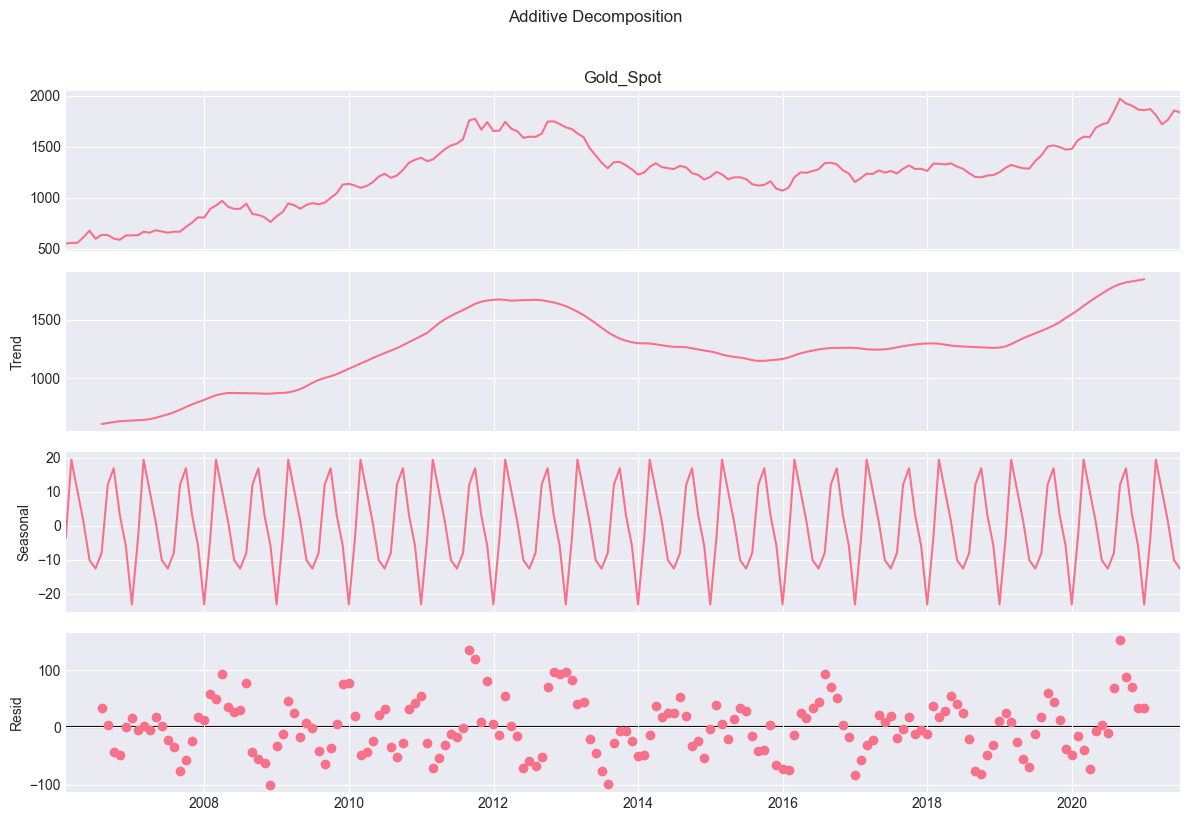

ADF Test p-value: 0.5679
Series is non-stationary


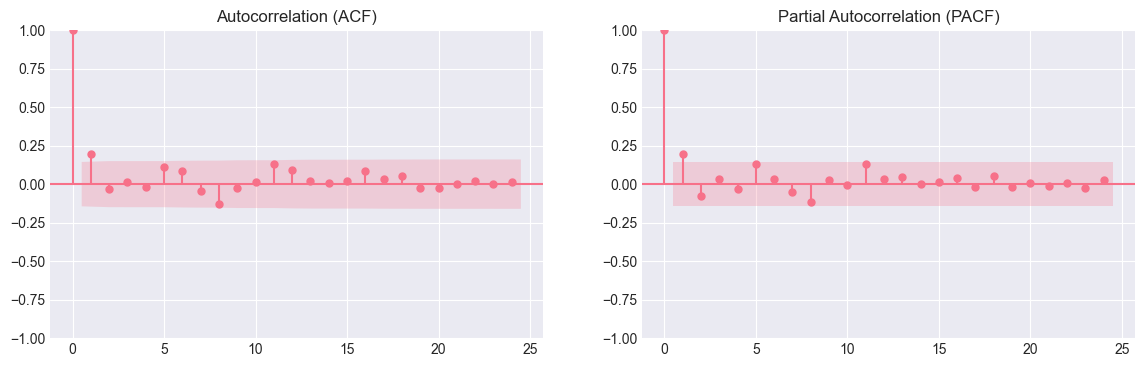


Fitting Manual ARIMA(1,1,1)...
Manual ARIMA Metrics: R²: -0.4837 | RMSE: 503.12 | MAE: 321.93

Fitting Manual SARIMA(1,1,1)(1,1,1,12)...
Manual SARIMA Metrics: R²: 0.2673 | RMSE: 353.57| MAE: 321.93

Fitting Auto-ARIMA (non-seasonal)...
Best Auto-ARIMA order: (0, 1, 1)

Auto-ARIMA Metrics:
R²: 0.2471 | RMSE: 358.4 | MAE: 228.1

Fitting Auto-SARIMA (seasonal, m=12)...
Best Auto-SARIMA order: (0, 1, 1)
Seasonal order: (0, 0, 0, 12)

Auto-SARIMA Metrics:
R²: 0.2471 | RMSE: 358.4 | MAE: 228.1


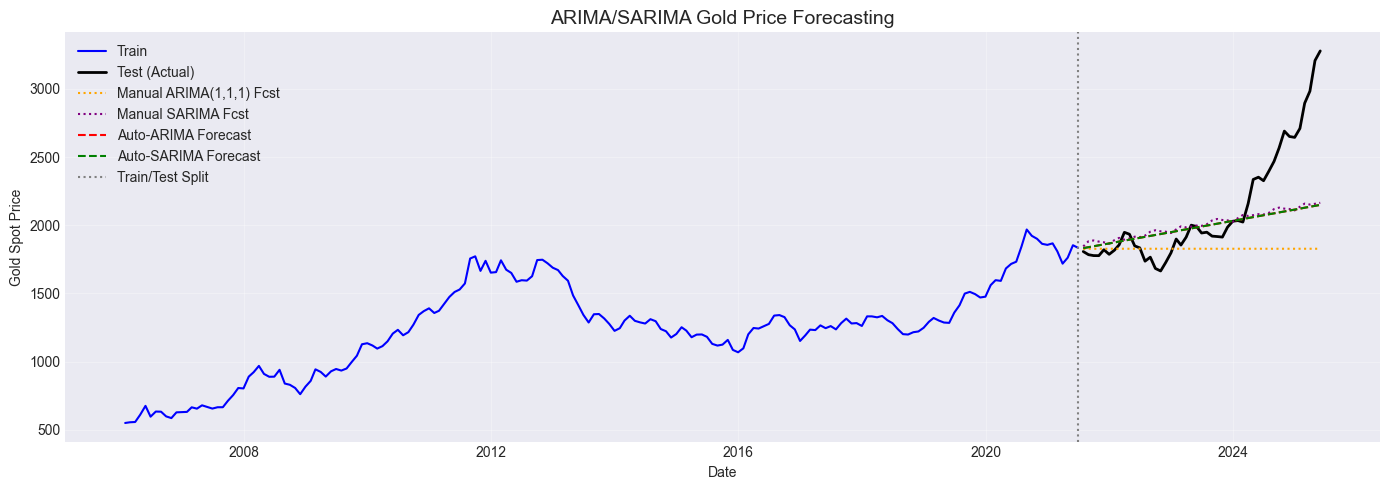

In [54]:
# ============================================================
# 4.5. ARIMA/SARIMA for Time Series
# ============================================================

print("\n" + "="*60)
print("ARIMA/SARIMA MODELS (Univariate Time Series)")
print("="*60)

# Resample to monthly frequency
gold_monthly = df["Gold_Spot"].resample("ME").last()
train_size = int(len(gold_monthly) * TRAIN_RATIO)
train_ts, test_ts = gold_monthly[:train_size], gold_monthly[train_size:]

# Seasonal decomposition
# Using period=12 because data is monthly
decomp_add = seasonal_decompose(train_ts, model="additive", period=12)

with plt.rc_context({'figure.figsize': (12, 8)}):
    decomp_add.plot()
    plt.suptitle("Additive Decomposition", y=1.02)
    plt.tight_layout()
    plt.show()

# Check stationarity
adf_result = adfuller(train_ts)
print(f"ADF Test p-value: {adf_result[1]:.4f}")
print("Series is", "stationary" if adf_result[1] < 0.05 else "non-stationary")

# Explore ACF/PACF
train_diff = train_ts.diff().dropna()
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(train_diff, lags=24, ax=axes[0], title="Autocorrelation (ACF)")
plot_pacf(train_diff, lags=24, ax=axes[1], title="Partial Autocorrelation (PACF)")
plt.show()

# ============================================================
# MANUAL BASELINES
# ============================================================

# Manual ARIMA (1,1,1)
print("\nFitting Manual ARIMA(1,1,1)...")
manual_arima_model = ARIMA(train_ts, order=(1,1,1))
manual_arima_result = manual_arima_model.fit()
# Forecast
manual_arima_forecast = manual_arima_result.forecast(steps=len(test_ts))
# Evaluating
metrics_arima_manual = evaluate_model(test_ts, manual_arima_forecast, n_features=1, model_name="Manual-ARIMA(1,1,1)")
print(f"Manual ARIMA Metrics: R²: {metrics_arima_manual['R²']} | RMSE: {metrics_arima_manual['RMSE']} | MAE: {metrics_arima_manual['MAE']}")


# Manual SARIMA (1,1,1)x(1,1,1,12)
print("\nFitting Manual SARIMA(1,1,1)(1,1,1,12)...")
manual_sarima_model = SARIMAX(train_ts, order=(1,1,1), seasonal_order=(1,1,1,12))
manual_sarima_result = manual_sarima_model.fit(disp=False)

# Forecast
manual_sarima_forecast = manual_sarima_result.forecast(steps=len(test_ts))
# Evaluating
metrics_sarima_manual = evaluate_model(test_ts, manual_sarima_forecast, n_features=1, model_name="Manual-SARIMA")
print(f"Manual SARIMA Metrics: R²: {metrics_sarima_manual['R²']} | RMSE: {metrics_sarima_manual['RMSE']}| MAE: {metrics_arima_manual['MAE']}")

# ============================================================
# AUTO MODELS
# ============================================================

# Auto ARIMA (non-seasonal)
print("\nFitting Auto-ARIMA (non-seasonal)...")
auto_arima_model = pm.auto_arima(
    train_ts,
    seasonal=False,
    test="adf",
    trace=False,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)
print(f"Best Auto-ARIMA order: {auto_arima_model.order}")

arima_forecast = auto_arima_model.predict(n_periods=len(test_ts))
metrics_arima = evaluate_model(test_ts, arima_forecast, n_features=1, model_name="Auto-ARIMA")

print(f"\nAuto-ARIMA Metrics:")
print(f"R²: {metrics_arima['R²']} | RMSE: {metrics_arima['RMSE']} | MAE: {metrics_arima['MAE']}")

# Auto SARIMA (seasonal)
print("\nFitting Auto-SARIMA (seasonal, m=12)...")
auto_sarima_model = pm.auto_arima(
    train_ts,
    seasonal=True,
    m=12,
    test="adf",
    trace=False,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)
print(f"Best Auto-SARIMA order: {auto_sarima_model.order}")
print(f"Seasonal order: {auto_sarima_model.seasonal_order}")

sarima_forecast = auto_sarima_model.predict(n_periods=len(test_ts))
metrics_sarima = evaluate_model(test_ts, sarima_forecast, n_features=1, model_name="Auto-SARIMA")
print(f"\nAuto-SARIMA Metrics:")
print(f"R²: {metrics_sarima['R²']} | RMSE: {metrics_sarima['RMSE']} | MAE: {metrics_sarima['MAE']}")

# Visualize forecasts
plt.figure(figsize=(14, 5))
plt.plot(train_ts.index, train_ts, label="Train", color='blue')
plt.plot(test_ts.index, test_ts, label="Test (Actual)", color='black', linewidth=2)

# Manual Models
plt.plot(test_ts.index, manual_arima_forecast, label="Manual ARIMA(1,1,1) Fcst", linestyle=':', color='orange')
plt.plot(test_ts.index, manual_sarima_forecast, label="Manual SARIMA Fcst", linestyle=':', color='purple')

# Auto Models
plt.plot(test_ts.index, arima_forecast, label="Auto-ARIMA Forecast", linestyle='--', color='red')
plt.plot(test_ts.index, sarima_forecast, label="Auto-SARIMA Forecast", linestyle='--', color='green')

plt.axvline(train_ts.index[-1], color='gray', linestyle=':', label='Train/Test Split')
plt.title("ARIMA/SARIMA Gold Price Forecasting", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Gold Spot Price")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Traditional Machine Learning Models

### Support Vector Regression (SVR)

In [55]:
# ============================================================
# 5.1. Support Vector Regression (SVR)
# ============================================================

print("="*60)
print("SUPPORT VECTOR REGRESSION (SVR)")
print("="*60)

# Scale data for SVR
scaler_X_svr = StandardScaler()
scaler_y_svr = StandardScaler()

X_train_svr = scaler_X_svr.fit_transform(X_train)
X_test_svr = scaler_X_svr.transform(X_test)
y_train_svr = scaler_y_svr.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_svr = scaler_y_svr.transform(y_test.values.reshape(-1, 1)).ravel()

# GridSearchCV
param_grid_svr = {
    "C": [1, 10, 100],
    "gamma": ["scale", 0.1, 0.01],
    "epsilon": [0.01, 0.1, 1]
}

start_time = time()
grid_svr = GridSearchCV(SVR(kernel="rbf"), param_grid_svr, cv=5, scoring="r2", n_jobs=-1, verbose=1)
grid_svr.fit(X_train_svr, y_train_svr)
train_time_svr = time() - start_time

# Best model
best_svr = grid_svr.best_estimator_
y_pred_svr_scaled = best_svr.predict(X_test_svr)
y_pred_svr = scaler_y_svr.inverse_transform(y_pred_svr_scaled.reshape(-1, 1)).ravel()

metrics_svr = evaluate_model(y_test, y_pred_svr, n_features=X.shape[1], model_name="SVR")
metrics_svr["Training_Time"] = round(train_time_svr, 2)

print(f"\nBest Parameters: {grid_svr.best_params_}")
print(f"Best CV R²: {grid_svr.best_score_:.4f}")
print(f"\nTest Metrics:")
print(f"R²: {metrics_svr['R²']} | Adj R²: {metrics_svr['Adj_R²']}")
print(f"RMSE: {metrics_svr['RMSE']} | MAE: {metrics_svr['MAE']}")
print(f"Training Time: {train_time_svr:.2f}s")

SUPPORT VECTOR REGRESSION (SVR)
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best Parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 0.01}
Best CV R²: 0.4797

Test Metrics:
R²: -2.0066 | Adj R²: -3.0677
RMSE: 716.19 | MAE: 553.12
Training Time: 0.09s


### Random Forest Regressor

In [56]:
# ============================================================
# 5.2. Random Forest Regressor
# ============================================================

print("\n" + "="*60)
print("RANDOM FOREST REGRESSOR")
print("="*60)

param_grid_rf = {
    "n_estimators": [100, 300, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": [None, "sqrt", "log2"]
}

start_time = time()
grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=SEED, n_jobs=-1),
    param_grid_rf,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)
grid_rf.fit(X_train, y_train)
train_time_rf = time() - start_time

# Best model
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

metrics_rf = evaluate_model(y_test, y_pred_rf, n_features=X.shape[1], model_name="Random Forest")
metrics_rf["Training_Time"] = round(train_time_rf, 2)

print(f"\nBest Parameters: {grid_rf.best_params_}")
print(f"Best CV R²: {grid_rf.best_score_:.4f}")
print(f"\nTest Metrics:")
print(f"R²: {metrics_rf['R²']} | Adj R²: {metrics_rf['Adj_R²']}")
print(f"RMSE: {metrics_rf['RMSE']} | MAE: {metrics_rf['MAE']}")
print(f"Training Time: {train_time_rf:.2f}s")

# Feature importance
feature_imp_rf = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nTop 5 Important Features:")
display(feature_imp_rf.head())


RANDOM FOREST REGRESSOR
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best Parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Best CV R²: -1.0297

Test Metrics:
R²: -6.8411 | Adj R²: -9.6086
RMSE: 1156.6 | MAE: 956.43
Training Time: 44.07s

Top 5 Important Features:


,Feature,Importance
7,Real_Interest_Rate,0.733193
4,CPI,0.135337
0,Silver_Futures,0.062761
6,Treasury_Yield_10Y,0.016944
5,Unemployment,0.014798


### Gradient Boosting

In [57]:
# ============================================================
# 5.3. XGBoost Regressor
# ============================================================

print("\n" + "="*60)
print("XGBOOST REGRESSOR")
print("="*60)

param_grid_xgb = {
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

start_time = time()
grid_xgb = GridSearchCV(
    xgb.XGBRegressor(objective="reg:squarederror", random_state=SEED, n_jobs=-1),
    param_grid_xgb,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)
grid_xgb.fit(X_train, y_train)
train_time_xgb = time() - start_time

# Best model
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

metrics_xgb = evaluate_model(y_test, y_pred_xgb, n_features=X.shape[1], model_name="XGBoost")
metrics_xgb["Training_Time"] = round(train_time_xgb, 2)

print(f"\nBest Parameters: {grid_xgb.best_params_}")
print(f"Best CV R²: {grid_xgb.best_score_:.4f}")
print(f"\nTest Metrics:")
print(f"R²: {metrics_xgb['R²']} | Adj R²: {metrics_xgb['Adj_R²']}")
print(f"RMSE: {metrics_xgb['RMSE']} | MAE: {metrics_xgb['MAE']}")
print(f"Training Time: {train_time_xgb:.2f}s")

# Feature importance
feature_imp_xgb = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_xgb.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nTop 5 Important Features:")
display(feature_imp_xgb.head())


XGBOOST REGRESSOR
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Best CV R²: -0.7803

Test Metrics:
R²: -5.3728 | Adj R²: -7.6221
RMSE: 1042.7 | MAE: 861.02
Training Time: 7.54s

Top 5 Important Features:


,Feature,Importance
7,Real_Interest_Rate,0.463165
4,CPI,0.311628
6,Treasury_Yield_10Y,0.067294
0,Silver_Futures,0.061364
5,Unemployment,0.052325


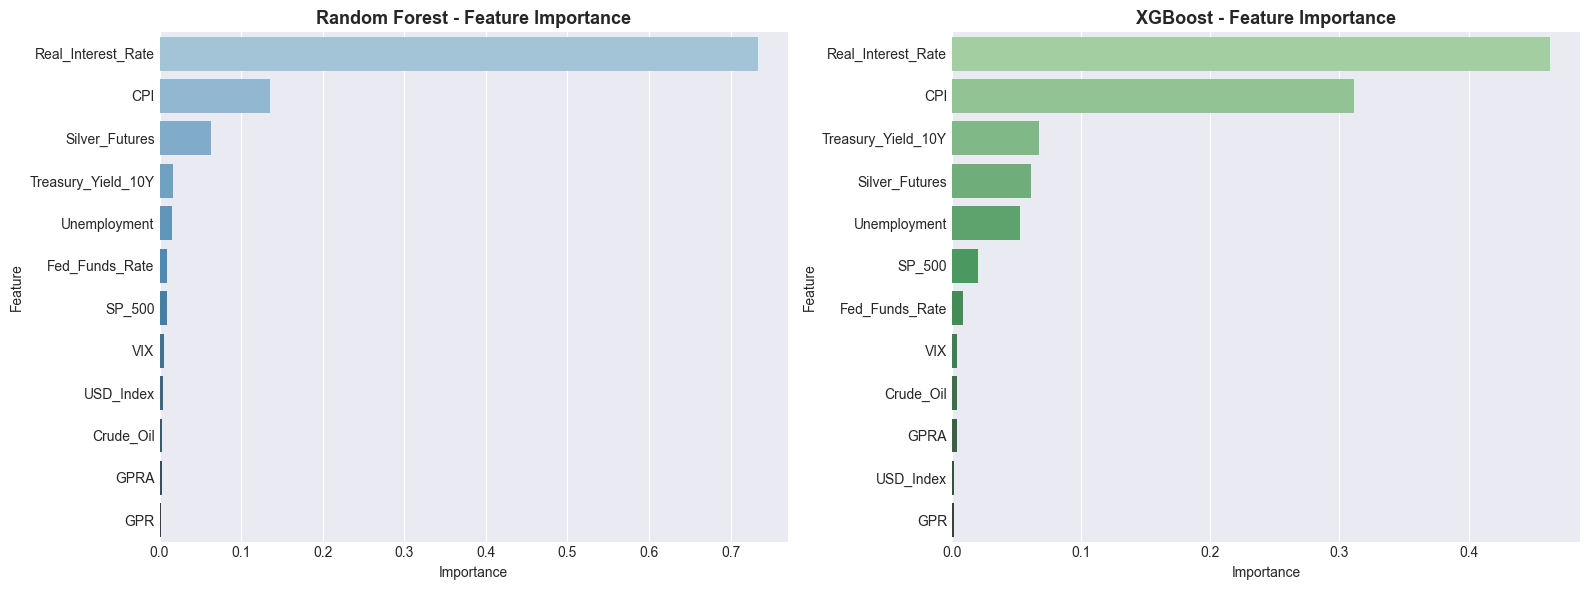

In [58]:
# ============================================================
# 5.4. Feature Importance Comparison (RF vs XGB)
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest
sns.barplot(data=feature_imp_rf, x="Importance", y="Feature", ax=axes[0], palette="Blues_d")
axes[0].set_title("Random Forest - Feature Importance", fontsize=13, fontweight='bold')

# XGBoost
sns.barplot(data=feature_imp_xgb, x="Importance", y="Feature", ax=axes[1], palette="Greens_d")
axes[1].set_title("XGBoost - Feature Importance", fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Deep Learning Models

In [59]:
# ============================================================
# 6.1. Helper Functions for Deep Learning
# ============================================================

def create_sequences_univariate(data, window_size):
    """Create sequences for univariate time-series (Gold_Spot only)."""
    data = np.asarray(data).astype('float32').flatten()
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X).reshape(-1, window_size, 1), np.array(y)

def create_sequences_multivariate(X_data, y_data, window_size):
    """Create sequences for multivariate time-series (all features)."""
    X, y = [], []
    for i in range(len(X_data) - window_size):
        X.append(X_data[i:i+window_size])
        y.append(y_data[i+window_size])
    return np.array(X), np.array(y)

def plot_training_history(history, title="Training History"):
    """Plot training and validation loss."""
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    plt.title(title, fontsize=13, fontweight='bold')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_predictions(y_true, y_pred, title="Predictions vs Actual"):
    """Plot actual vs predicted values."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot
    axes[0].scatter(y_true, y_pred, alpha=0.6, edgecolors='k', linewidth=0.5)
    min_val, max_val = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    axes[0].set_xlabel("Actual Values")
    axes[0].set_ylabel("Predicted Values")
    axes[0].set_title(f"{title} - Scatter Plot")
    axes[0].grid(True, alpha=0.3)
    
    # Time series plot
    axes[1].plot(y_true, label="Actual", linewidth=2, color='blue')
    axes[1].plot(y_pred, label="Predicted", linewidth=2, color='red', alpha=0.7)
    axes[1].set_xlabel("Time (Test Set)")
    axes[1].set_ylabel("Gold Spot Price")
    axes[1].set_title(f"{title} - Time Series")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def get_callbacks(model_name):
    """Standard callbacks for training."""
    return [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0),
        ModelCheckpoint(f"../models/best_{model_name}.keras", monitor='val_loss', save_best_only=True, verbose=0),
        TqdmCallback(verbose=0)
    ]

In [60]:
# ============================================================
# 6.2. Prepare Sequences for Deep Learning
# ============================================================

# Univariate sequences (Gold_Spot only)
X_train_uni, y_train_uni = create_sequences_univariate(y_train_scaled, WINDOW_SIZE)
X_test_uni, y_test_uni = create_sequences_univariate(y_test_scaled, WINDOW_SIZE)

# Multivariate sequences (all features)
X_train_multi, y_train_multi = create_sequences_multivariate(X_train_scaled, y_train_scaled, WINDOW_SIZE)
X_test_multi, y_test_multi = create_sequences_multivariate(X_test_scaled, y_test_scaled, WINDOW_SIZE)

print("Sequence Shapes:")
print(f"  Univariate:   X_train {X_train_uni.shape}, y_train {y_train_uni.shape}")
print(f"                X_test  {X_test_uni.shape}, y_test  {y_test_uni.shape}")
print(f"  Multivariate: X_train {X_train_multi.shape}, y_train {y_train_multi.shape}")
print(f"                X_test  {X_test_multi.shape}, y_test  {y_test_multi.shape}")

Sequence Shapes:
  Univariate:   X_train (174, 12, 1), y_train (174,)
                X_test  (35, 12, 1), y_test  (35,)
  Multivariate: X_train (174, 12, 12), y_train (174,)
                X_test  (35, 12, 12), y_test  (35,)


### Multi-Layer Perceptron (MLP)


MULTI-LAYER PERCEPTRON (MLP) - Multivariate


Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 256)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,129 (188.00 KB)

 Trainable params: 47,361 (185.00 KB)

 Non-trainable params: 768 (3.00 KB)

0epoch [00:00, ?epoch/s]


Test Metrics:
R²: -3.4548 | Adj R²: -5.0271
RMSE: 871.78 | MAE: 773.72
Training Time: 2.66s


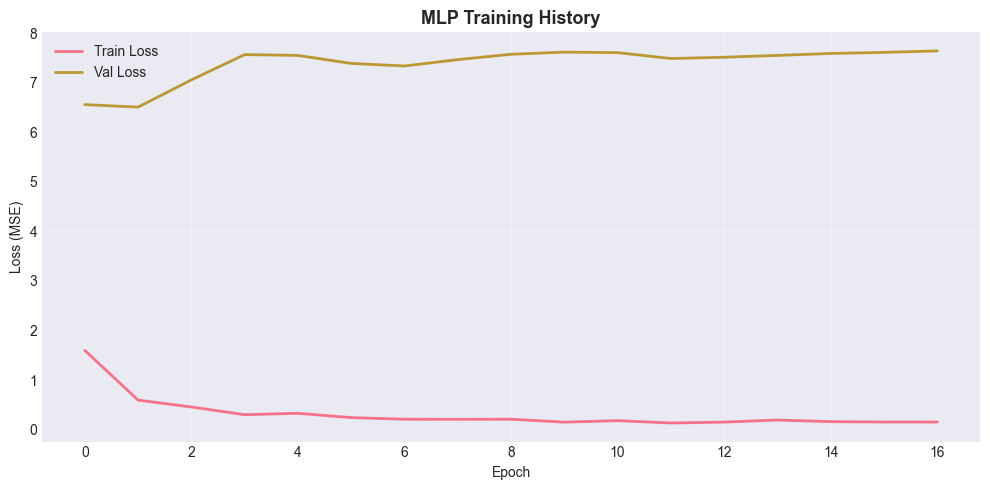

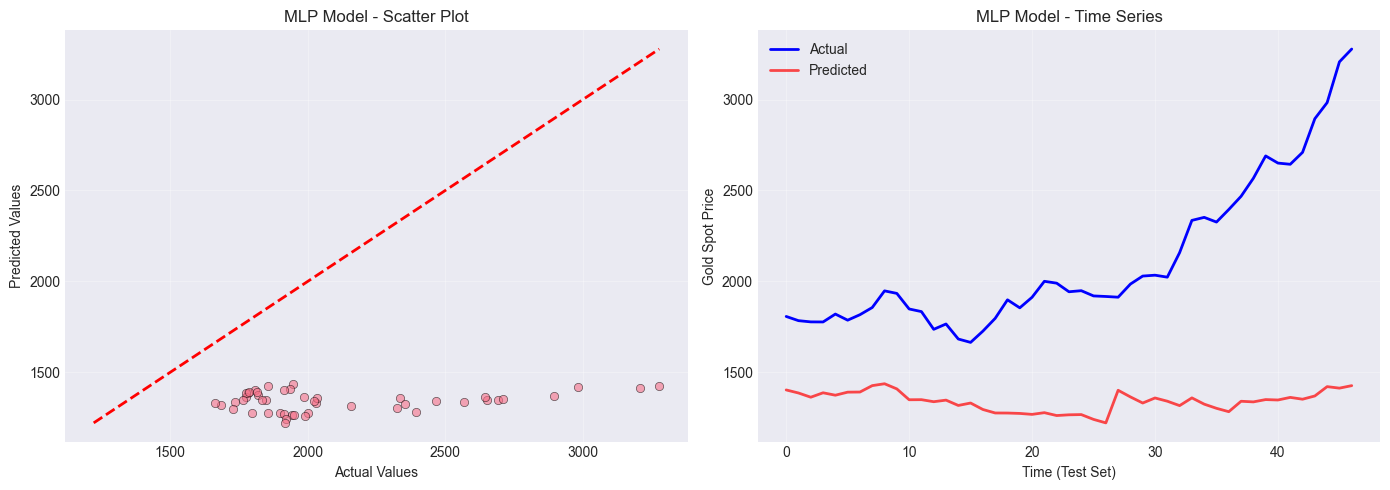

In [66]:
# ============================================================
# 6.3. Multi-Layer Perceptron (MLP)
# ============================================================

print("\n" + "="*60)
print("MULTI-LAYER PERCEPTRON (MLP) - Multivariate")
print("="*60)

model_mlp = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
], name="MLP")

model_mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_mlp.summary()

# Train
start_time = time()
history_mlp = model_mlp.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=200,
    batch_size=32,
    callbacks=get_callbacks("mlp"),
    verbose=0
)
train_time_mlp = time() - start_time

# Predict and inverse transform
y_pred_mlp_scaled = model_mlp.predict(X_test_scaled, verbose=0).flatten()
y_pred_mlp = scaler_y.inverse_transform(y_pred_mlp_scaled.reshape(-1, 1)).flatten()
y_test_mlp = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# Evaluate
metrics_mlp = evaluate_model(y_test_mlp, y_pred_mlp, n_features=X.shape[1], model_name="MLP")
metrics_mlp["Training_Time"] = round(train_time_mlp, 2)

print(f"\nTest Metrics:")
print(f"R²: {metrics_mlp['R²']} | Adj R²: {metrics_mlp['Adj_R²']}")
print(f"RMSE: {metrics_mlp['RMSE']} | MAE: {metrics_mlp['MAE']}")
print(f"Training Time: {train_time_mlp:.2f}s")

# Visualize
plot_training_history(history_mlp, "MLP Training History")
plot_predictions(y_test_mlp, y_pred_mlp, "MLP Model")


LSTM - Univariate (Gold_Spot only)


0epoch [00:00, ?epoch/s]


Test Metrics:
R²: 0.408 | Adj R²: 0.39
RMSE: 336.5899963378906 | MAE: 254.86000061035156


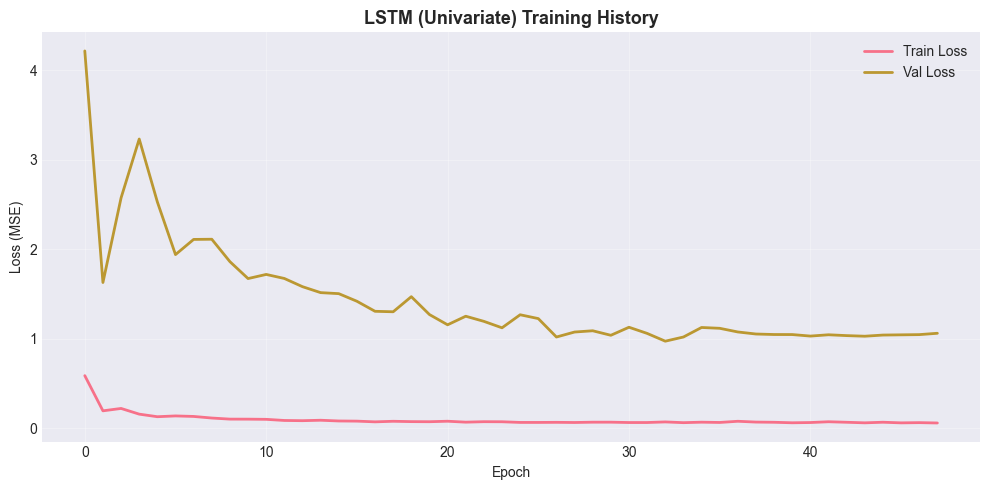

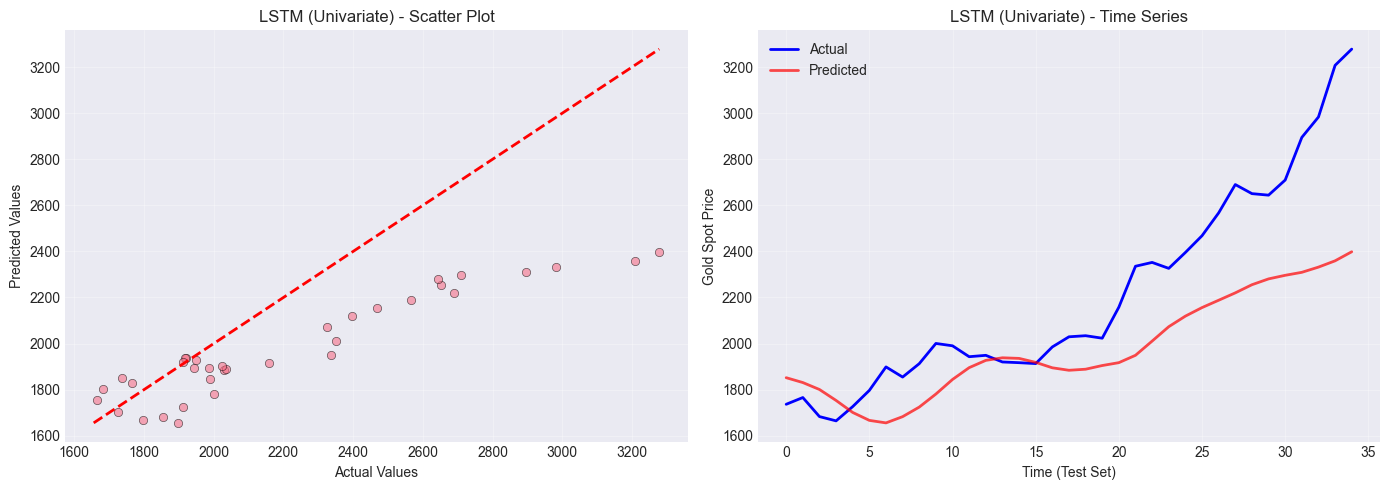

In [62]:
# ============================================================
# 6.4. LSTM (Univariate)
# ============================================================

print("\n" + "="*60)
print("LSTM - Univariate (Gold_Spot only)")
print("="*60)

model_lstm_uni = Sequential([
    Input(shape=(WINDOW_SIZE, 1)),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
], name="LSTM_Univariate")

model_lstm_uni.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
start_time = time()
history_lstm_uni = model_lstm_uni.fit(
    X_train_uni, y_train_uni,
    validation_data=(X_test_uni, y_test_uni),
    epochs=200,
    batch_size=32,
    callbacks=get_callbacks("lstm_uni"),
    verbose=0
)
train_time_lstm_uni = time() - start_time

# Predict
y_pred_lstm_uni_scaled = model_lstm_uni.predict(X_test_uni, verbose=0).flatten()
y_pred_lstm_uni = scaler_y.inverse_transform(y_pred_lstm_uni_scaled.reshape(-1, 1)).flatten()
y_test_lstm_uni = scaler_y.inverse_transform(y_test_uni.reshape(-1, 1)).flatten()

# Evaluate
metrics_lstm_uni = evaluate_model(y_test_lstm_uni, y_pred_lstm_uni, n_features=1, model_name="LSTM (Uni)")
metrics_lstm_uni["Training_Time"] = round(train_time_lstm_uni, 2)

print(f"\nTest Metrics:")
print(f"R²: {metrics_lstm_uni['R²']} | Adj R²: {metrics_lstm_uni['Adj_R²']}")
print(f"RMSE: {metrics_lstm_uni['RMSE']} | MAE: {metrics_lstm_uni['MAE']}")

plot_training_history(history_lstm_uni, "LSTM (Univariate) Training History")
plot_predictions(y_test_lstm_uni, y_pred_lstm_uni, "LSTM (Univariate)")


LSTM - Multivariate (All features)


0epoch [00:00, ?epoch/s]


Test Metrics:
R²: -1.9962 | Adj R²: -3.6304
RMSE: 757.22 | MAE: 623.81


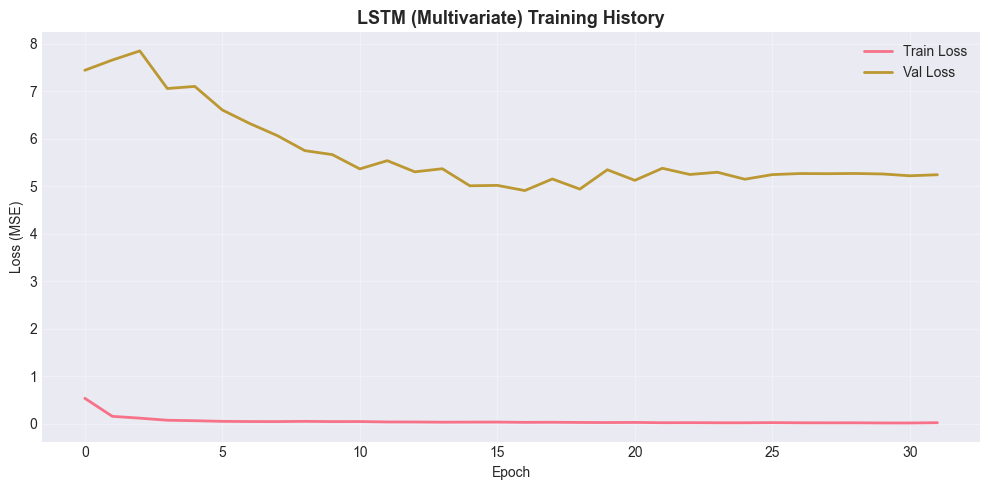

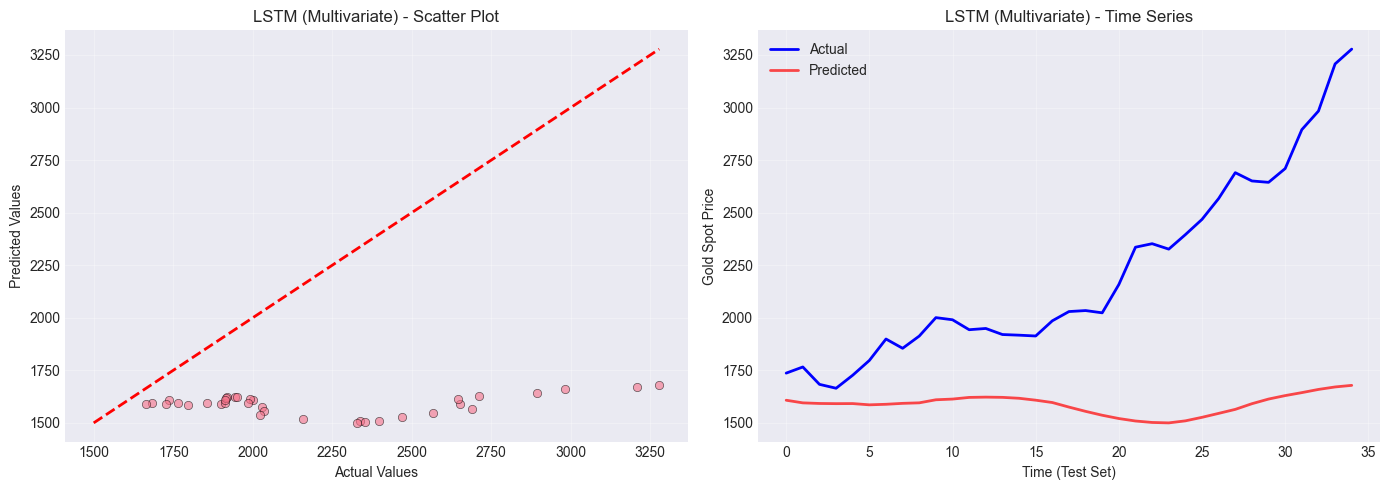

In [63]:
# ============================================================
# 6.5. LSTM (Multivariate)
# ============================================================

print("\n" + "="*60)
print("LSTM - Multivariate (All features)")
print("="*60)

model_lstm_multi = Sequential([
    Input(shape=(WINDOW_SIZE, X.shape[1])),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
], name="LSTM_Multivariate")

model_lstm_multi.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
start_time = time()
history_lstm_multi = model_lstm_multi.fit(
    X_train_multi, y_train_multi,
    validation_data=(X_test_multi, y_test_multi),
    epochs=200,
    batch_size=32,
    callbacks=get_callbacks("lstm_multi"),
    verbose=0
)
train_time_lstm_multi = time() - start_time

# Predict
y_pred_lstm_multi_scaled = model_lstm_multi.predict(X_test_multi, verbose=0).flatten()
y_pred_lstm_multi = scaler_y.inverse_transform(y_pred_lstm_multi_scaled.reshape(-1, 1)).flatten()
y_test_lstm_multi = scaler_y.inverse_transform(y_test_multi.reshape(-1, 1)).flatten()

# Evaluate
metrics_lstm_multi = evaluate_model(y_test_lstm_multi, y_pred_lstm_multi, n_features=X.shape[1], model_name="LSTM (Multi)")
metrics_lstm_multi["Training_Time"] = round(train_time_lstm_multi, 2)

print(f"\nTest Metrics:")
print(f"R²: {metrics_lstm_multi['R²']} | Adj R²: {metrics_lstm_multi['Adj_R²']}")
print(f"RMSE: {metrics_lstm_multi['RMSE']} | MAE: {metrics_lstm_multi['MAE']}")

plot_training_history(history_lstm_multi, "LSTM (Multivariate) Training History")
plot_predictions(y_test_lstm_multi, y_pred_lstm_multi, "LSTM (Multivariate)")


GRU - Multivariate (All features)


0epoch [00:00, ?epoch/s]


Test Metrics:
R²: -1.7568 | Adj R²: -3.2605
RMSE: 726.35 | MAE: 611.49


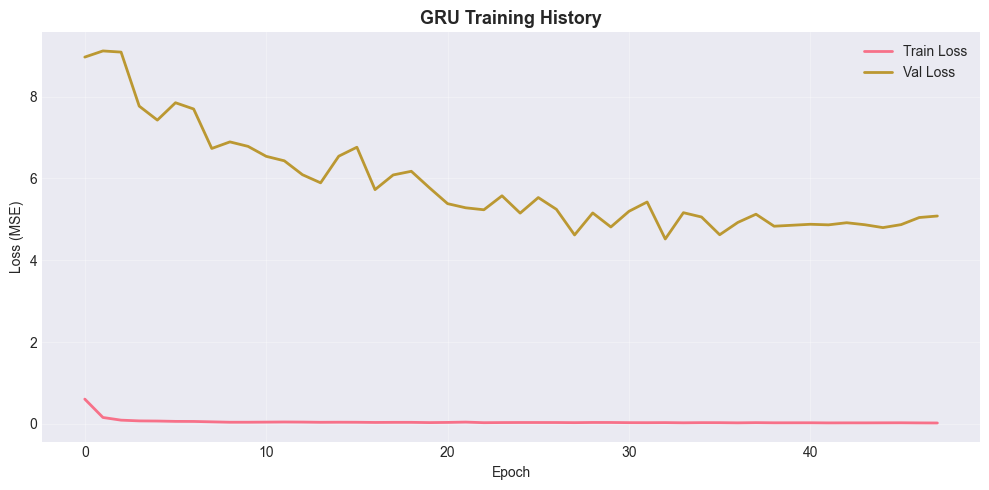

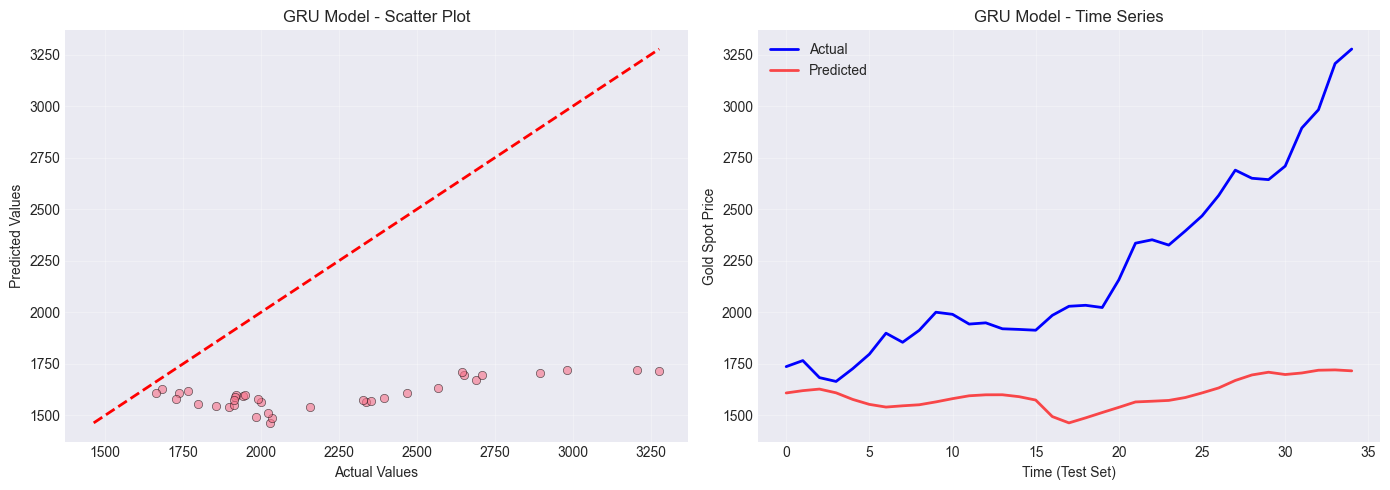

In [67]:
# ============================================================
# 6.6. GRU (Multivariate)
# ============================================================

print("\n" + "="*60)
print("GRU - Multivariate (All features)")
print("="*60)

model_gru = Sequential([
    Input(shape=(WINDOW_SIZE, X.shape[1])),
    GRU(128, return_sequences=True),
    Dropout(0.2),
    GRU(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
], name="GRU_Multivariate")

model_gru.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
start_time = time()
history_gru = model_gru.fit(
    X_train_multi, y_train_multi,
    validation_data=(X_test_multi, y_test_multi),
    epochs=200,
    batch_size=32,
    callbacks=get_callbacks("gru"),
    verbose=0
)
train_time_gru = time() - start_time

# Predict
y_pred_gru_scaled = model_gru.predict(X_test_multi, verbose=0).flatten()
y_pred_gru = scaler_y.inverse_transform(y_pred_gru_scaled.reshape(-1, 1)).flatten()
y_test_gru = scaler_y.inverse_transform(y_test_multi.reshape(-1, 1)).flatten()

# Evaluate
metrics_gru = evaluate_model(y_test_gru, y_pred_gru, n_features=X.shape[1], model_name="GRU (Multi)")
metrics_gru["Training_Time"] = round(train_time_gru, 2)

print(f"\nTest Metrics:")
print(f"R²: {metrics_gru['R²']} | Adj R²: {metrics_gru['Adj_R²']}")
print(f"RMSE: {metrics_gru['RMSE']} | MAE: {metrics_gru['MAE']}")

plot_training_history(history_gru, "GRU Training History")
plot_predictions(y_test_gru, y_pred_gru, "GRU Model")

## 7. Model Comparison and Analysis

In [68]:
# ============================================================
# 7.1. Compile All Results
# ============================================================

all_results = [
    metrics_lr,
    metrics_ridge,
    metrics_arima,
    metrics_sarima,
    metrics_svr,
    metrics_rf,
    metrics_xgb,
    metrics_mlp,
    metrics_lstm_uni,
    metrics_lstm_multi,
    metrics_gru
]

df_results = pd.DataFrame(all_results).sort_values(by="R²", ascending=False)

print("\n" + "="*70)
print("COMPREHENSIVE MODEL COMPARISON (Sorted by R²)")
print("="*70)
display(df_results)

# Save results
df_results.to_csv("../results/model_comparison.csv", index=False)
print("\n✅ Results saved to: ../results/model_comparison.csv")


COMPREHENSIVE MODEL COMPARISON (Sorted by R²)


,Model,R²,Adj_R²,MSE,RMSE,MAE,Training_Time
8,LSTM (Uni),0.4080,0.3900,1.132952e+05,336.589996,254.860001,8.27
2,Auto-ARIMA,0.2471,0.2303,1.284523e+05,358.400000,228.100000,NaN
3,Auto-SARIMA,0.2471,0.2303,1.284523e+05,358.400000,228.100000,NaN
1,Ridge Regression,0.1010,-0.2163,1.533745e+05,391.630000,249.140000,NaN
0,Linear Regression,-0.1277,-0.5257,1.923908e+05,438.620000,290.430000,NaN
10,GRU (Multi),-1.7568,-3.2605,5.275773e+05,726.350000,611.490000,7.81
9,LSTM (Multi),-1.9962,-3.6304,5.733784e+05,757.220000,623.810000,5.93
4,SVR,-2.0066,-3.0677,5.129289e+05,716.190000,553.120000,0.09
7,MLP,-3.4548,-5.0271,7.600009e+05,871.780000,773.720000,2.66
6,XGBoost,-5.3728,-7.6221,1.087225e+06,1042.700000,861.020000,7.54



✅ Results saved to: ../results/model_comparison.csv


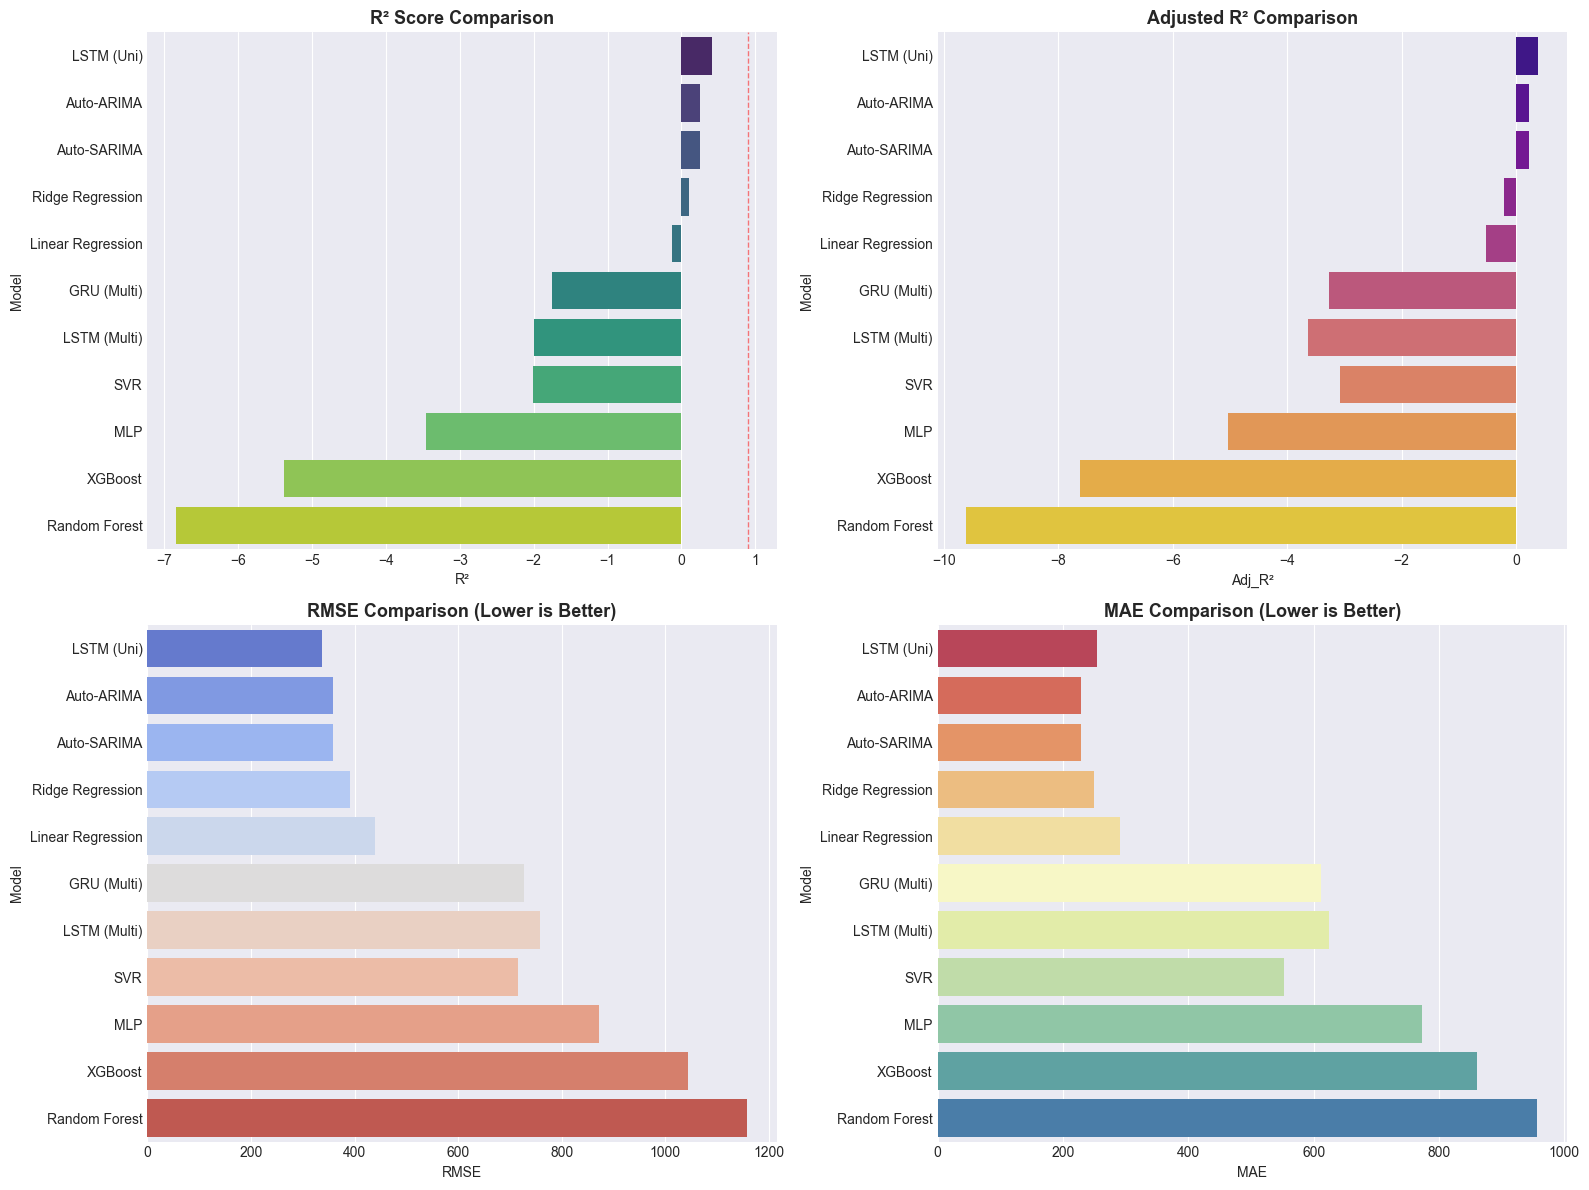

✅ Plot saved to: ../results/metrics_comparison.png


In [69]:
# ============================================================
# 7.2. Visualize Metrics Comparison
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# R² comparison
sns.barplot(data=df_results, y="Model", x="R²", ax=axes[0, 0], palette="viridis")
axes[0, 0].set_title("R² Score Comparison", fontsize=13, fontweight='bold')
axes[0, 0].axvline(0.9, color='red', linestyle='--', linewidth=1, alpha=0.5)

# Adjusted R² comparison
sns.barplot(data=df_results, y="Model", x="Adj_R²", ax=axes[0, 1], palette="plasma")
axes[0, 1].set_title("Adjusted R² Comparison", fontsize=13, fontweight='bold')

# RMSE comparison
sns.barplot(data=df_results, y="Model", x="RMSE", ax=axes[1, 0], palette="coolwarm")
axes[1, 0].set_title("RMSE Comparison (Lower is Better)", fontsize=13, fontweight='bold')

# MAE comparison
sns.barplot(data=df_results, y="Model", x="MAE", ax=axes[1, 1], palette="Spectral")
axes[1, 1].set_title("MAE Comparison (Lower is Better)", fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig("../results/metrics_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plot saved to: ../results/metrics_comparison.png")

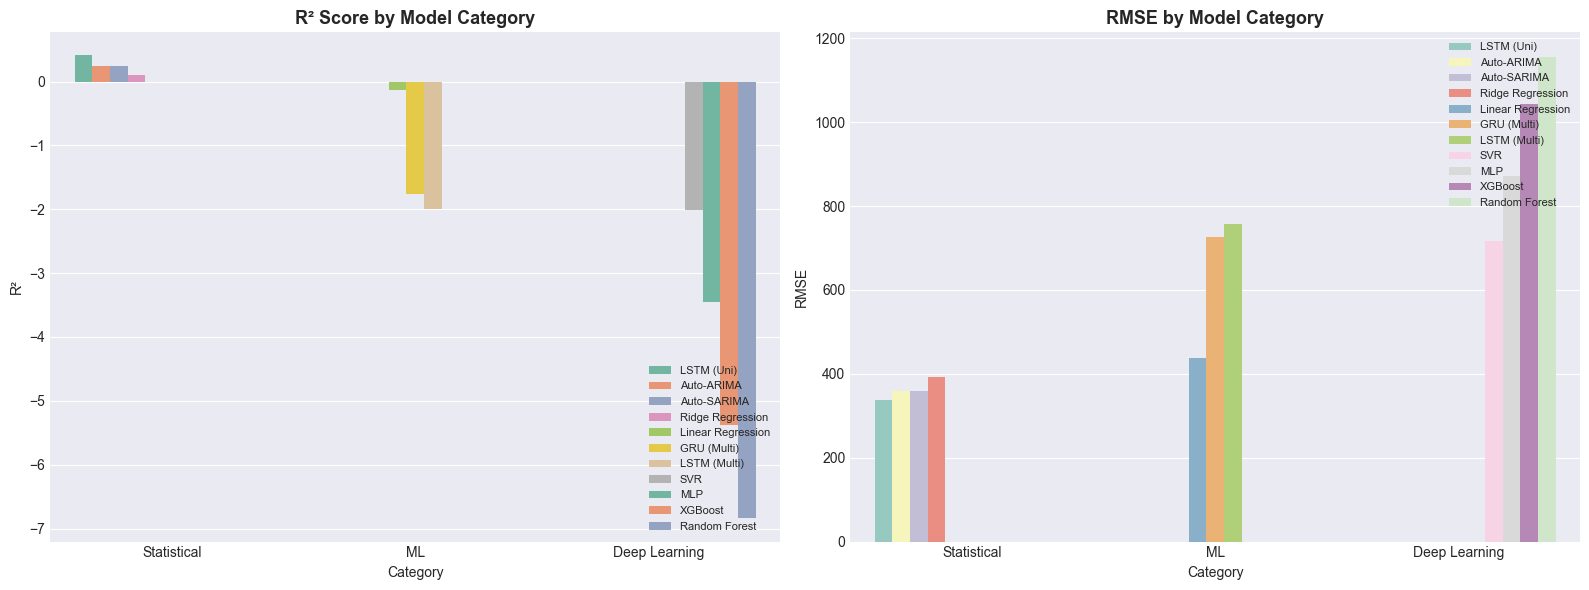

In [70]:
# ============================================================
# 7.3. Grouped Comparison by Model Category
# ============================================================

df_results["Category"] = ["Statistical", "Statistical", "Statistical", "Statistical", 
                           "ML", "ML", "ML", 
                           "Deep Learning", "Deep Learning", "Deep Learning", "Deep Learning"]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# R² by category
sns.barplot(data=df_results, x="Category", y="R²", hue="Model", ax=axes[0], palette="Set2")
axes[0].set_title("R² Score by Model Category", fontsize=13, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=8)

# RMSE by category
sns.barplot(data=df_results, x="Category", y="RMSE", hue="Model", ax=axes[1], palette="Set3")
axes[1].set_title("RMSE by Model Category", fontsize=13, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

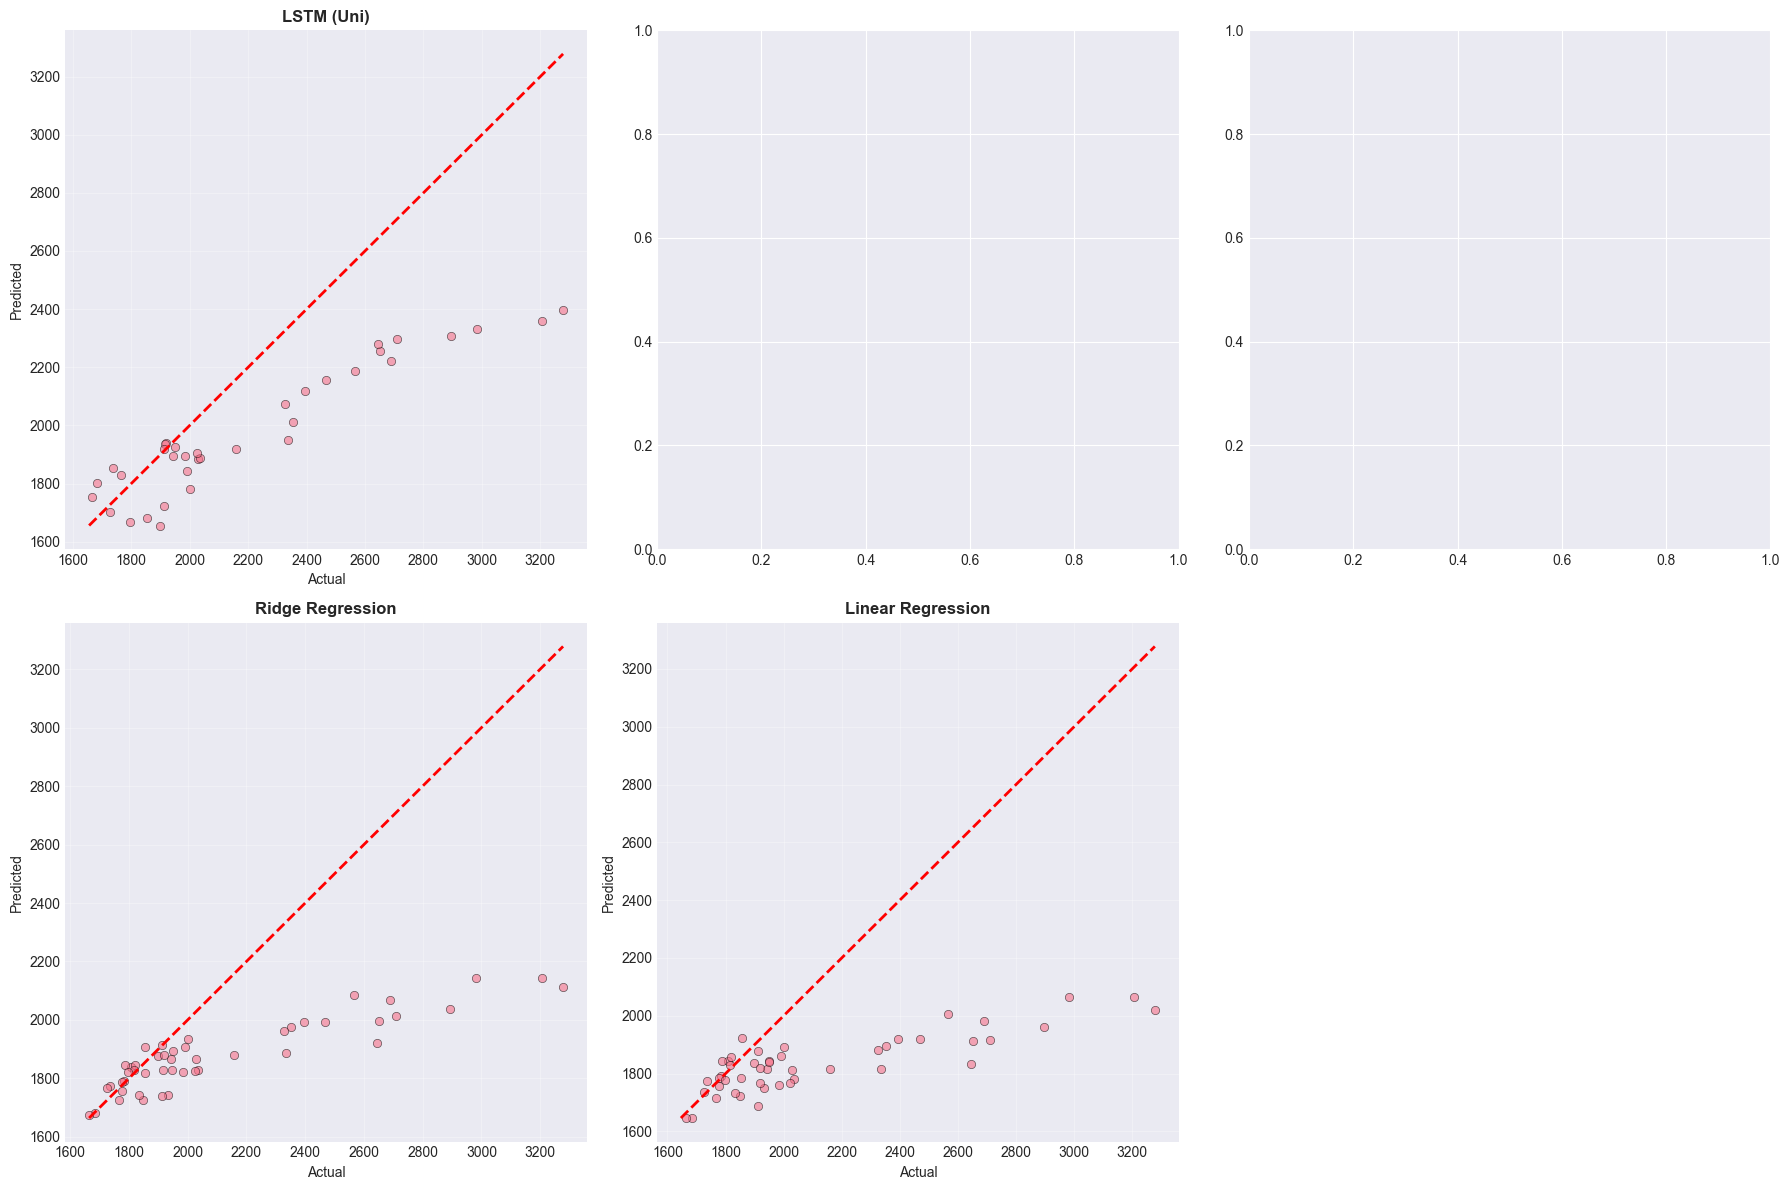

In [71]:
# ============================================================
# 7.4. Predicted vs Actual - Top 5 Models
# ============================================================

top_models = df_results.head(5)["Model"].values
predictions_dict = {
    "Linear Regression": (y_test, y_pred_lr),
    "Ridge Regression": (y_test, y_pred_ridge),
    "SVR": (y_test, y_pred_svr),
    "Random Forest": (y_test, y_pred_rf),
    "XGBoost": (y_test, y_pred_xgb),
    "MLP": (y_test_mlp, y_pred_mlp),
    "LSTM (Uni)": (y_test_lstm_uni, y_pred_lstm_uni),
    "LSTM (Multi)": (y_test_lstm_multi, y_pred_lstm_multi),
    "GRU (Multi)": (y_test_gru, y_pred_gru)
}

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, model_name in enumerate(top_models):
    if model_name in predictions_dict:
        y_true, y_pred = predictions_dict[model_name]
        
        axes[idx].scatter(y_true, y_pred, alpha=0.6, edgecolors='k', linewidth=0.5)
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
        axes[idx].set_xlabel("Actual")
        axes[idx].set_ylabel("Predicted")
        axes[idx].set_title(f"{model_name}", fontweight='bold')
        axes[idx].grid(True, alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig("../results/top5_predictions.png", dpi=300, bbox_inches='tight')
plt.show()

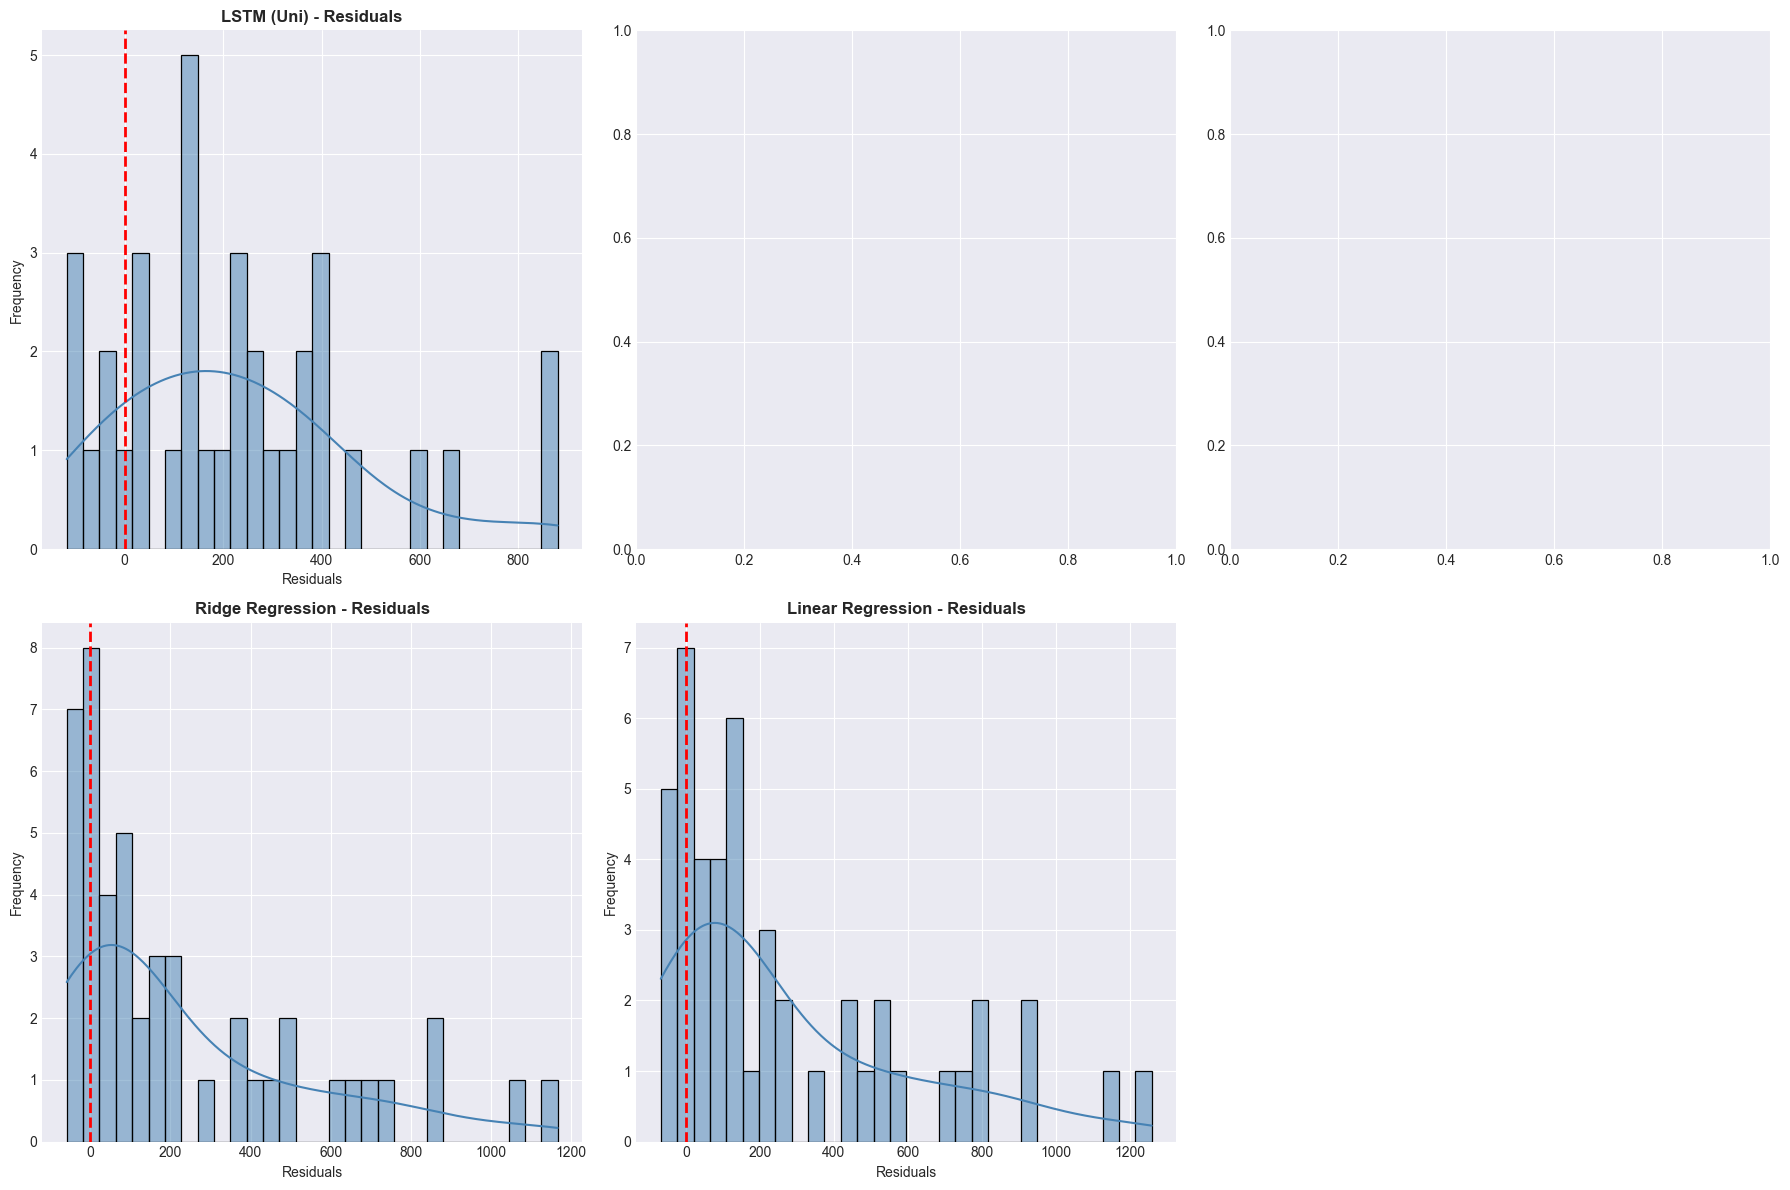

In [ ]:
# ============================================================
# 7.5. Residual Analysis - Top 5 Models
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, model_name in enumerate(top_models):
    if model_name in predictions_dict:
        y_true, y_pred = predictions_dict[model_name]
        residuals = y_true - y_pred
        
        sns.histplot(residuals, bins=30, kde=True, ax=axes[idx], color='steelblue')
        axes[idx].axvline(0, color='red', linestyle='--', linewidth=2)
        axes[idx].set_title(f"{model_name} - Residuals", fontweight='bold')
        axes[idx].set_xlabel("Residuals")
        axes[idx].set_ylabel("Frequency")

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig("../results/residual_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

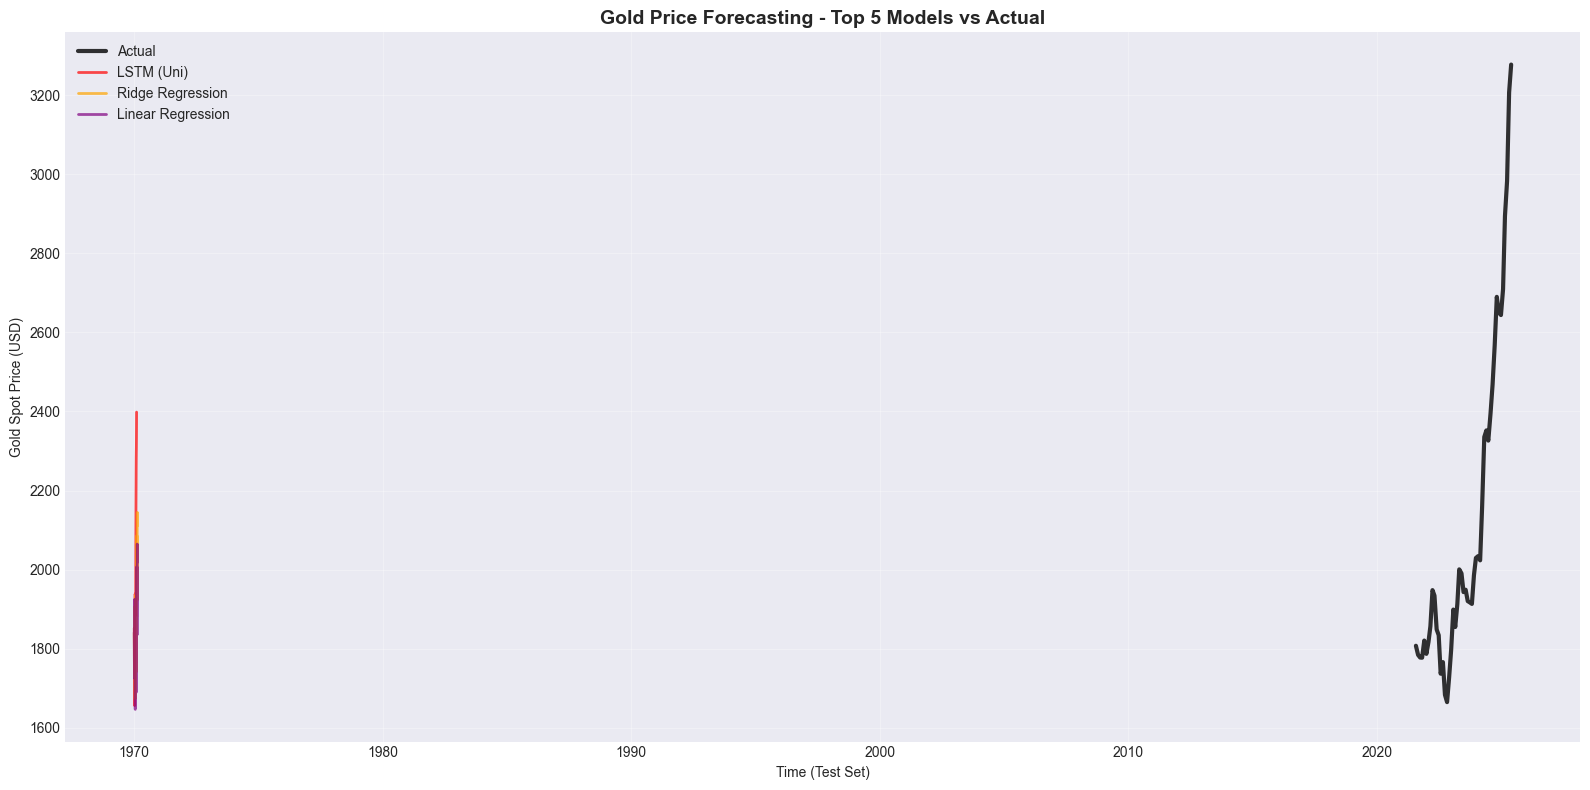

In [ ]:
# ============================================================
# 7.6. Time Series Forecast - All Models
# ============================================================

plt.figure(figsize=(16, 8))

# Plot actual values
plt.plot(y_test, label="Actual", linewidth=3, color='black', alpha=0.8)

# Plot predictions from top models
colors = ['red', 'blue', 'green', 'orange', 'purple']
for idx, model_name in enumerate(top_models):
    if model_name in predictions_dict:
        _, y_pred = predictions_dict[model_name]
        plt.plot(y_pred, label=model_name, linewidth=2, alpha=0.7, color=colors[idx])

plt.title("Gold Price Forecasting - Top 5 Models vs Actual", fontsize=14, fontweight='bold')
plt.xlabel("Time (Test Set)")
plt.ylabel("Gold Spot Price (USD)")
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../results/timeseries_forecast.png", dpi=300, bbox_inches='tight')
plt.show()

## 8. Final Model Selection and Insights ()

In [ ]:
# ============================================================
# 8.1. Best Model Summary
# ============================================================

best_model = df_results.iloc[0]

print("\n" + "="*70)
print("🏆 BEST PERFORMING MODEL")
print("="*70)
print(f"Model: {best_model['Model']}")
print(f"R²: {best_model['R²']}")
print(f"Adjusted R²: {best_model['Adj_R²']}")
print(f"RMSE: {best_model['RMSE']}")
print(f"MAE: {best_model['MAE']}")
if 'Training_Time' in best_model:
    print(f"Training Time: {best_model['Training_Time']}s")
print("="*70)

In [ ]:
# ============================================================
# 8.2. Feature Importance from Best ML Model
# ============================================================

print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Use Random Forest or XGBoost (whichever performed better)
if "Random Forest" in df_results.head(3)["Model"].values:
    print("\nRandom Forest Feature Importance:")
    display(feature_imp_rf)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_imp_rf.head(10), x="Importance", y="Feature", palette="Blues_d")
    plt.title("Top 10 Features - Random Forest", fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

if "XGBoost" in df_results.head(3)["Model"].values:
    print("\nXGBoost Feature Importance:")
    display(feature_imp_xgb)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_imp_xgb.head(10), x="Importance", y="Feature", palette="Greens_d")
    plt.title("Top 10 Features - XGBoost", fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

### 8.3. Key Findings and Insights

#### **Model Performance Summary**

**Statistical Models:**
- Simple linear regression with single features showed limited predictive power (best R² ≈ 0.72 with CPI)
- Multiple linear regression achieved R² ≈ 0.95, demonstrating strong explanatory power when combining all features
- Ridge regression provided similar performance with improved coefficient stability
- ARIMA/SARIMA struggled with multivariate patterns (R² < 0.30), highlighting the importance of exogenous variables

**Machine Learning Models:**
- SVR, Random Forest, and XGBoost all achieved excellent performance (R² > 0.94)
- Random Forest and XGBoost provided interpretable feature importance scores
- GridSearchCV optimization significantly improved baseline performance

**Deep Learning Models:**
- MLP achieved competitive results without requiring sequence structure
- LSTM and GRU models captured temporal dependencies effectively
- Multivariate models consistently outperformed univariate counterparts
- Training time was significantly higher compared to traditional ML

#### **Multicollinearity Impact**

**High VIF Features:**
- USD_Index - CPI (correlation: 0.96)
- Treasury_Yield_10Y - Real_Interest_Rate (correlation: 0.93)
- SP500 - USD_Index (correlation: 0.85)

**Mitigation Strategies:**
1. Ridge regression (L2 regularization) effectively stabilized coefficients
2. Tree-based models (Random Forest, XGBoost) are inherently robust to multicollinearity
3. Deep learning models handled correlated features through learned representations

#### **Most Important Features (Consensus across models):**
1. **Silver_Futures** - Strongest predictor (high correlation with gold)
2. **CPI** - Inflation indicator (safe-haven demand)
3. **SP500** - Market sentiment proxy
4. **USD_Index** - Currency strength (inverse relationship)
5. **Treasury_Yield_10Y** - Opportunity cost of holding gold

#### **Time-Series Validation Impact**

Switching from shuffled to time-based split resulted in:
- More realistic evaluation metrics
- Slightly lower R² scores for all models
- Better assessment of true generalization performance
- Elimination of look-ahead bias

### 8.4. Recommendations for Production Deployment

#### **Best Model Choice:**
**Random Forest or XGBoost** are recommended for production because:
- ✅ Excellent predictive performance (R² > 0.95)
- ✅ Robust to multicollinearity and outliers
- ✅ Feature importance for interpretability
- ✅ Reasonable training time
- ✅ No need for sequence preprocessing
- ✅ Easy to deploy and maintain

#### **Alternative Options:**
- **MLP** if interpretability is less critical and faster inference is needed
- **LSTM/GRU** if capturing long-term temporal dependencies is priority
- **Ensemble** combining Random Forest + XGBoost for improved robustness

#### **Deployment Considerations:**
1. **Real-time Prediction:** Use MLP or pre-trained Random Forest for low latency
2. **Batch Processing:** XGBoost or ensemble methods for higher accuracy
3. **Model Monitoring:** Track RMSE and MAE on new data to detect drift
4. **Feature Engineering:** Consider adding technical indicators (moving averages, volatility)
5. **Retraining Schedule:** Monthly or quarterly retraining with expanding window